In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.stats.mstats import gmean
from sklearn.linear_model import LinearRegression
%matplotlib inline
from itertools import combinations
from itertools import chain
import sys
import os
import copy
sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

fgm_simulation_path = '/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/Simulations/FGM_simulation_callable.py'
sys.path.append(os.path.dirname(os.path.expanduser(fgm_simulation_path)))
from FGM_simulation_callable import simulation, nball_pull, gaussian_fitness

tools_path = '../code/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools
from tools import mutant_colorset
from tools import condition_colorset

In [2]:
cov_thresh = 1e6
# fitness_data = p.read_csv('../data/fitnesses_merged_NoWeight_plusflat_resample1000000.csv')
# fitness_data = p.read_csv('../data/fitnesses_merged_NoWeight_wTechnicalandResamples_ByTimepoint.csv')
fitness_data = p.read_csv('../data/fitnesses_merged_NoWeight_wTechnical_ByTimepoint.csv')
# fitness_data = p.read_csv('../data/fitnesses_merged_default_technical_timepoint.csv')

In [3]:
df_merged_predictions = p.read_csv('../../StarryNight/fitness_prediction_40x_pergen_moreneutrals_BATCH_master_100steps_stepsize2_2xmax_D1to6.csv',index_col=0)

df_merged_predictions = df_merged_predictions[df_merged_predictions['dimension']==0]

barcodes = np.unique(df_merged_predictions['barcode'].values)
conditions = np.unique(df_merged_predictions['condition'].values)

fitnesses = {}

for condition in conditions:
    fitnesses[condition] = []
    for bc in barcodes:
        fitnesses[condition].append(df_merged_predictions[(df_merged_predictions['barcode']==bc) & (df_merged_predictions['condition']==condition)]['fitness'].values[0])

In [4]:
old_data = p.DataFrame()
old_data['barcode'] = barcodes
for condition in conditions:
    old_data[f'{condition}_fitness'] = fitnesses[condition]
merged_fitness_data = p.merge(fitness_data,old_data,on='barcode')

In [43]:
mutant_train_set = p.read_csv('../data/mutant_train_set.csv')
training_bcs = mutant_train_set['barcode'].values

mutant_minimal_train_set = p.read_csv('../data/mutant_minimal_train_set.csv')
minimal_training_bcs = mutant_minimal_train_set['barcode'].values

mutant_minimal_train_set = p.read_csv('../data/mutant_minimal_test_set.csv')
minimal_testing_bcs = mutant_minimal_train_set['barcode'].values

In [46]:
len(minimal_training_bcs)

21

In [47]:
len(minimal_testing_bcs)

136

In [6]:
old_conditions = {
                  '3':['3.1','3.2','3.3'],
#                   '6':['6.1','6.2','6.3'],
                  '13':['13.1','13.2','13.3'],
                  '18':['18.1','18.2','18.3'],
                  '20':['20.1','20.2','20.3'],
                  '21':['21.1','21.2','21.3'],
                  '23':['23.1','23.2','23.3']
                 }

bigbatch_conditions = {
                        '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
                        '1BB_0.2MNaCl' :['K','L'],
                        '1BB_0.2MKCl' :['O'],
                        '1BB_0.5MKCl' :['P'],
#                         '1BB_8.5uMGdA' :['Q','R'],
#                         '1BB_17uMGdA' :['S','T'],
#                         '1BB_2ugFlu' :['U','V'],
#                         '1BB_0.5ugFlu' :['W','X'],
                        '1BB_1%Raf' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD'],
#                         '1BB_1%EtOH' :['EE','FF'],
#                         '1BB_SucRaf' :['GG'],
                      }

old_nonm3_conditions = ['1.4Glucose', '1.6Glucose', '1.7Glucose', '1.8Glucose',
       '2.5Glucose', '24_Hour_Transfer_PC', 'Benomyl_2ug/mL',
       'DMSO', 'Ferm_40_Hour_Transfer', 'Ferm_44_Hour_Transfer',
       'Ferm_50_Hour_Transfer', 'Ferm_54_Hour_Transfer',
       'Fluconazole_2ug/mL', 'Geldanamycin8.5uM','Radicicol_5uM', 'Resp_5_Day_Transfer',
       'Resp_7_Day_Transfer']

# m3_conditions = {**old_conditions,}
conditions = {**old_conditions, **bigbatch_conditions}
all_conditions = conditions.keys()
all_reps = [rep for reps in conditions.values() for rep in reps]

m3_conditions = list(old_conditions.keys()) + ['1BB_M3']
m3_reps = [rep for condition in m3_conditions for rep in conditions[condition]]



In [7]:
full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))

In [8]:
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

fitness_cols = [col for col in this_data.columns if '_fitness' in col]

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]


In [9]:
bigbatch_conditions.keys()

dict_keys(['1BB_M3', '1BB_Baffle', '1BB_1.4%Gluc', '1BB_1.8%Gluc', '1BB_0.2MNaCl', '1BB_0.2MKCl', '1BB_0.5MKCl', '1BB_1%Raf', '1BB_0.5%Raf', '1BB_1%Gly'])

In [101]:
this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

train_cols = [col + '_fitness' for col in m3_conditions]
test_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in train_cols]
test_cols = test_cols + [col + '_fitness' for col in old_nonm3_conditions]

fitness_cols = train_cols + test_cols

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

# train_cols = [col+'_original_fitness' for col in [col.split('_')[0] for col in fitness_cols] if col in m3_reps]
# test_cols =  [col+'_original_fitness'  for col in [col.split('_')[0] for col in fitness_cols] if col not in m3_reps]



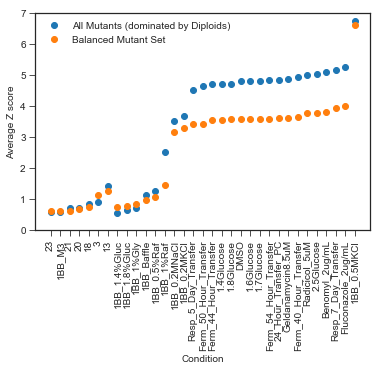

In [102]:
train_means = np.nanmean(this_data[train_cols].values,axis=1)
repeated_means = np.repeat(train_means,len(test_cols)).reshape(len(train_means),len(test_cols))
train_stds = np.nanstd(this_data[train_cols].values,axis=1)
repeated_stds = np.repeat(train_stds,len(test_cols)).reshape(len(train_stds),len(test_cols))
test_z_scores = np.abs((this_data[test_cols].values-repeated_means)/repeated_stds)

train_means = np.nanmean(this_data[train_cols].values,axis=1)
repeated_means = np.repeat(train_means,len(train_cols)).reshape(len(train_means),len(train_cols))
train_stds = np.nanstd(this_data[train_cols].values,axis=1)
repeated_stds = np.repeat(train_stds,len(train_cols)).reshape(len(train_stds),len(train_cols))
train_z_scores = np.abs((this_data[train_cols].values-repeated_means)/repeated_stds)

sorted_test_cols = np.asarray(test_cols)[np.argsort(np.mean(test_z_scores,axis=0))]
sorted_train_cols = np.asarray(train_cols)[np.argsort(np.mean(train_z_scores,axis=0))]
plt.plot(sorted(np.mean(train_z_scores,axis=0))+sorted(np.mean(test_z_scores,axis=0)),'o',label='All Mutants (dominated by Diploids)')


all_cols = list(sorted_train_cols)+list(sorted_test_cols)
plt.xticks(range(len(all_cols)),[col.split('_fitness')[0] for col in (all_cols)],rotation=90)





train_means = np.nanmean(this_data[train_cols].values[all_mut_locs,:],axis=1)
repeated_means = np.repeat(train_means,len(test_cols)).reshape(len(train_means),len(test_cols))
train_stds = np.nanstd(this_data[train_cols].values[all_mut_locs,:],axis=1)
repeated_stds = np.repeat(train_stds,len(test_cols)).reshape(len(train_stds),len(test_cols))
test_z_scores = np.abs((this_data[test_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

train_means = np.nanmean(this_data[train_cols].values[all_mut_locs,:],axis=1)
repeated_means = np.repeat(train_means,len(train_cols)).reshape(len(train_means),len(train_cols))
train_stds = np.nanstd(this_data[train_cols].values[all_mut_locs,:],axis=1)
repeated_stds = np.repeat(train_stds,len(train_cols)).reshape(len(train_stds),len(train_cols))
train_z_scores = np.abs((this_data[train_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

sorted_test_cols = np.asarray(test_cols)[np.argsort(np.mean(test_z_scores,axis=0))]
sorted_train_cols = np.asarray(train_cols)[np.argsort(np.mean(train_z_scores,axis=0))]
plt.plot(sorted(np.mean(train_z_scores,axis=0))+sorted(np.mean(test_z_scores,axis=0)),'o',label='Balanced Mutant Set')


all_cols = list(sorted_train_cols)+list(sorted_test_cols)
plt.xticks(range(len(all_cols)),[col.split('_fitness')[0] for col in (all_cols)],rotation=90)

plt.legend()
plt.ylim(0,7)
plt.ylabel('Average Z score')
plt.xlabel('Condition')

plt.savefig('z_scores_minimal_comparison.pdf',bbox_inches='tight')

In [104]:
train_cols = list(sorted_train_cols) + list(sorted_test_cols[np.where(np.asarray(sorted(np.mean(test_z_scores,axis=0)))<2)[0]])
test_cols = list(sorted_test_cols[np.where(np.asarray(sorted(np.mean(test_z_scores,axis=0)))>2)[0]])

In [105]:
train_cols

['23_fitness',
 '1BB_M3_fitness',
 '21_fitness',
 '20_fitness',
 '18_fitness',
 '3_fitness',
 '13_fitness',
 '1BB_1.4%Gluc_fitness',
 '1BB_1.8%Gluc_fitness',
 '1BB_1%Gly_fitness',
 '1BB_Baffle_fitness',
 '1BB_0.5%Raf_fitness',
 '1BB_1%Raf_fitness']

In [106]:
test_cols

['1BB_0.2MNaCl_fitness',
 '1BB_0.2MKCl_fitness',
 'Resp_5_Day_Transfer_fitness',
 'Ferm_50_Hour_Transfer_fitness',
 'Ferm_44_Hour_Transfer_fitness',
 '1.4Glucose_fitness',
 '1.8Glucose_fitness',
 'DMSO_fitness',
 '1.6Glucose_fitness',
 '1.7Glucose_fitness',
 'Ferm_54_Hour_Transfer_fitness',
 '24_Hour_Transfer_PC_fitness',
 'Geldanamycin8.5uM_fitness',
 'Ferm_40_Hour_Transfer_fitness',
 'Radicicol_5uM_fitness',
 '2.5Glucose_fitness',
 'Benomyl_2ug/mL_fitness',
 'Resp_7_Day_Transfer_fitness',
 'Fluconazole_2ug/mL_fitness',
 '1BB_0.5MKCl_fitness']

1BB_0.2MNaCl
1BB_0.2MKCl
Resp_5_Day_Transfer
Ferm_50_Hour_Transfer
Ferm_44_Hour_Transfer
1.4Glucose
1.8Glucose
DMSO
1.6Glucose
1.7Glucose
Ferm_54_Hour_Transfer
24_Hour_Transfer_PC
Geldanamycin8.5uM
Ferm_40_Hour_Transfer
Radicicol_5uM
2.5Glucose
Benomyl_2ug/mL
Resp_7_Day_Transfer
Fluconazole_2ug/mL
1BB_0.5MKCl
1BB_0.2MNaCl
1BB_0.2MKCl
Resp_5_Day_Transfer
Ferm_50_Hour_Transfer
Ferm_44_Hour_Transfer
1.4Glucose
1.8Glucose
DMSO
1.6Glucose
1.7Glucose
Ferm_54_Hour_Transfer
24_Hour_Transfer_PC
Geldanamycin8.5uM
Ferm_40_Hour_Transfer
Radicicol_5uM
2.5Glucose
Benomyl_2ug/mL
Resp_7_Day_Transfer
Fluconazole_2ug/mL
1BB_0.5MKCl


(-2, 13)

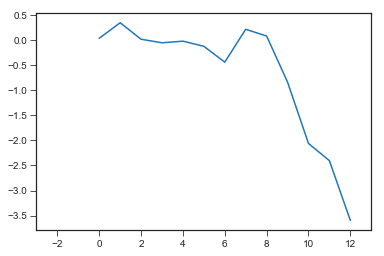

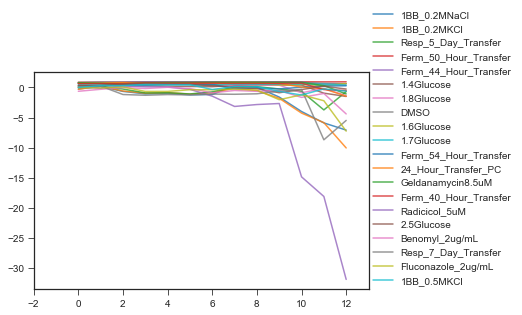

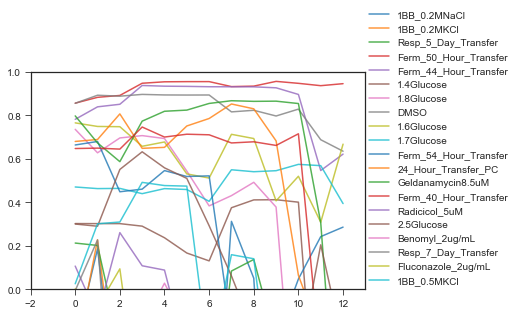

In [112]:

this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

# train_cols = [col + '_fitness' for col in m3_conditions]
# test_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in train_cols]
# test_cols = test_cols + [col + '_fitness' for col in old_nonm3_conditions]
# train_cols = list(sorted_train_cols) + list(sorted_test_cols)[:5]
# test_cols = list(sorted_test_cols)[5:]

fitness_cols = train_cols + test_cols

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

# train_cols = [col+'_original_fitness' for col in [col.split('_')[0] for col in fitness_cols] if col in m3_reps]
# test_cols =  [col+'_original_fitness'  for col in [col.split('_')[0] for col in fitness_cols] if col not in m3_reps]




# fitness_cols = fitness_data.columns

train_conditions = train_cols

train_conditions = train_cols

# train_conditions = test_cols
train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

test_conditions = test_cols
# test_conditions = train_cols
# test_conditions = [rep for rep in  test_conditions if rep.split('_')[0] in all_reps]
test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]




all_locs = sorted(list(train_locs)+list(test_locs))

used_mutants = [bc for bc in this_data['barcode'].values if bc in (list(minimal_training_bcs) + list(minimal_testing_bcs))]
                                       
all_mut_locs =sorted(list(np.where(np.isin(this_data['barcode'].values,used_mutants))[0]))

this_fitness = fitness[all_mut_locs,:][:,all_locs]
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]



train = [new_train_locs,np.where(np.isin(used_mutants,minimal_training_bcs))[0]]
test = [new_test_locs,np.where(np.isin(used_mutants,minimal_testing_bcs))[0]]


by_rank, by_condition, by_mutant, mean_fits, guesses = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=True)
by_condition = np.asarray(by_condition).swapaxes(0,1)

condition_colors = sns.color_palette()
plt.plot(by_rank)
plt.xlim(-3,len(by_rank))


plt.figure()
start = 0
already_plotted = []

for k,condition in enumerate(test_conditions):
    condition = condition.split('_fitness')[0]
    print(condition)
#     condition_name = [name for name, reps in conditions.items() for rep in reps if rep == condition][0]
    condition_name = condition
#     index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
    
    index =  k % len(condition_colors)
    if condition_name not in already_plotted:
        plt.plot(by_condition[k],label=condition_name,color=condition_colors[index],alpha=0.8)
        already_plotted.append(condition_name)
    else:
        plt.plot(by_condition[k],color=condition_colors[index],alpha=0.8)
plt.legend(loc=(1.0,0.0))
plt.xlim(-2,len(by_rank))

plt.figure()
start = 0
already_plotted = []

for k,condition in enumerate(test_conditions):
    condition = condition.split('_fitness')[0]
    print(condition)
#     condition_name = [name for name, reps in conditions.items() for rep in reps if rep == condition][0]
    condition_name = condition
#     index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
    
    index =  k % len(condition_colors)
    if condition_name not in already_plotted:
        plt.plot(by_condition[k],label=condition_name,color=condition_colors[index],alpha=0.8)
        already_plotted.append(condition_name)
    else:
        plt.plot(by_condition[k],color=condition_colors[index],alpha=0.8)
plt.legend(loc=(1.0,0.0))
plt.ylim(0,1)
plt.xlim(-2,len(by_rank))

In [21]:
condition_uncertainties = {}

# train_conditions = m3_conditions
train_conditions = train_cols

for condition in train_conditions:
    all_cols = []
    for rep in conditions[condition.split('_fitness')[0]]:
        for t in range(5):
            repT = f'{rep}_T{t}to{t+1}_fitness'
            if  repT in fitness_data.columns:
                all_cols.append(repT)
                      
    condition_uncertainties[condition] = (np.nanmean(fitness_data[all_cols],axis=1),np.nanstd(fitness_data[all_cols],axis=1))
                

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [22]:
for train_col in train_cols:
    for i in range(100):
        fitness_data[f"{train_col.split('_fitness')[0]}_bootstrap{i}_fitness"] = np.random.normal(condition_uncertainties[train_col][0],condition_uncertainties[train_col][1])

In [19]:
train_cols

['18_fitness',
 '1BB_M3_fitness',
 '21_fitness',
 '23_fitness',
 '20_fitness',
 '3_fitness',
 '13_fitness',
 '1BB_1.4%Gluc_fitness',
 '1BB_1.8%Gluc_fitness',
 '1BB_1%Gly_fitness',
 '1BB_Baffle_fitness',
 '1BB_0.5%Raf_fitness']

In [20]:
for bc in range(n_mutants):
    plt.plot(fitness_data[train_cols+test_cols].values[bc],alpha=0.3)
    
plt.ylim(-0.5,1.2)
plt.xticks(range(len(train_cols+test_cols)),train_cols+test_cols,rotation=90)
    

KeyError: "['3' '13' '18' '20' '21' '23' '1BB_M3'] not in index"

(-1.1, 1.1)

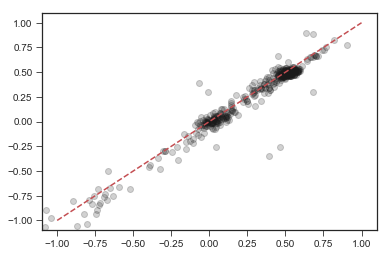

In [225]:
plt.scatter(fitness_data['1BB_0.2MKCl_fitness'],fitness_data['1BB_0.2MNaCl_fitness'],color='k',alpha=0.2)
plt.plot([-1,1],[-1,1],'r--')
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

In [21]:

# train_cols = [col for col in m3_conditions]
for train_col in train_cols:
    for i in range(100):
        fitness_data[f"{train_col.split('_fitness')[0]}_bootstrap{i}_fitness"] = np.random.normal(condition_uncertainties[train_col][0],condition_uncertainties[train_col][1])

In [22]:
fitness_data

,barcode,gene,type,ploidy,class,additional_muts,13.1_T1to2_error,13.1_T1to2_fitness,13.1_T2to3_error,13.1_T2to3_fitness,...,1BB_M3_bootstrap90_fitness,1BB_M3_bootstrap91_fitness,1BB_M3_bootstrap92_fitness,1BB_M3_bootstrap93_fitness,1BB_M3_bootstrap94_fitness,1BB_M3_bootstrap95_fitness,1BB_M3_bootstrap96_fitness,1BB_M3_bootstrap97_fitness,1BB_M3_bootstrap98_fitness,1BB_M3_bootstrap99_fitness
0,53,Diploid,Diploid,Diploid,Diploid,TIP1-upstream_point_variant; YKR012C-upstream_...,1.0,0.580425,1.0,0.030067,...,0.238190,0.242584,0.427084,0.284088,0.380275,0.456464,0.303083,0.367105,0.316805,0.091074
1,151,IRA1,stop_gained,Haploid,PKA,"MIM1,tS-upstream_indel_variant; SEH1-missense_...",1.0,1.745087,1.0,1.564600,...,1.166912,1.167679,0.851127,1.043162,1.086940,1.206866,0.952321,0.801136,1.116633,1.129109
2,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.0,0.312625,1.0,0.124529,...,0.424067,0.272346,0.199963,0.396126,0.228771,0.303236,0.353293,0.595599,0.404775,0.417677
3,273,IRA1,frameshift_variant,Haploid,PKA,None,1.0,1.366066,1.0,1.129782,...,1.023975,0.603634,0.920606,0.749770,0.776658,0.803294,0.668233,0.732203,0.769492,0.769154
4,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.0,1.177475,1.0,1.197848,...,0.602252,0.711713,0.732698,0.910651,0.762331,0.778761,0.794054,0.694434,0.795185,0.704076
5,415,IRA1,frameshift_variant,Haploid,PKA,None,1.0,1.462660,1.0,1.488640,...,0.920567,1.098619,1.163340,1.358994,0.710746,1.090912,0.850928,0.770805,1.277580,1.018340
6,499,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.0,1.373115,1.0,1.244172,...,-1.879157,-1.879157,-1.879157,-1.879157,-1.879157,-1.879157,-1.879157,-1.879157,-1.879157,-1.879157
7,622,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.0,0.667436,1.0,-0.216333,...,0.565339,0.246751,0.263488,0.601357,0.107456,0.620666,0.207057,0.317261,0.434778,0.405318
8,689,IRA1,frameshift_variant,Haploid,PKA,RPL19A-upstream_point_variant,1.0,1.484334,1.0,1.240727,...,1.135329,0.848379,0.929509,0.951428,1.006633,0.996354,1.033642,1.014558,0.765349,0.921636
9,697,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.0,0.430802,1.0,0.174890,...,0.102908,0.287925,0.349310,0.494622,0.289439,0.344511,0.386432,0.452919,0.226105,0.318941


In [23]:
this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

bests = []
ranks = []

train_cols = [col + '_fitness' for col in m3_conditions]
test_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in train_cols]
test_cols = test_cols + [col + '_fitness' for col in old_nonm3_conditions]

fitness_cols = train_cols + test_cols

train_locs = np.where(np.isin(fitness_cols,train_cols))[0]
test_locs = np.where(np.isin(fitness_cols,test_cols))[0]

all_locs = sorted(list(train_locs)+list(test_locs))

fitness = this_data[fitness_cols].values
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]

this_fitness = fitness[:,all_locs]

test_mutants = np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]

mean_guess = tools.var_explained(this_fitness[test_mutants,:][:,new_test_locs],np.repeat(np.mean(this_fitness[test_mutants,:][:,new_train_locs],axis=1),len(new_test_locs)).reshape(len(test_mutants),len(new_test_locs)))

for bootstrap in [False]+ list(range(100)):
    if bootstrap != False:
        train_cols = [col.split('_fitness')[0] + f'_bootstrap{bootstrap}_fitness' for col in m3_conditions]
        test_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in train_cols]

    else:

        train_cols = [col + '_fitness' for col in m3_conditions]
        test_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in train_cols]


    fitness_cols = train_cols + test_cols

    fitness = this_data[fitness_cols].values

    n_mutants = fitness.shape[0]
    n_conditions = fitness.shape[1]
    
    train_conditions = train_cols

    # train_conditions = test_cols
    train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

    test_conditions = test_cols
    # test_conditions = train_cols
    # test_conditions = [rep for rep in  test_conditions if rep.split('_')[0] in all_reps]
    test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]




    all_locs = sorted(list(train_locs)+list(test_locs))

    this_fitness = fitness[:,all_locs]
    new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
    new_test_locs = np.where(np.isin(all_locs,test_locs))[0]



    train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
    test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]


    by_rank, by_condition, by_mutant, mean_fits, guesses = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=True)
    by_condition = np.asarray(by_condition).swapaxes(0,1)
    
#     bests.append(max(by_rank))
    bests.append(by_rank[1])
    
    ranks.append(np.where(by_rank==max(by_rank))[0])


KeyError: "['3_bootstrap1_fitness' '13_bootstrap1_fitness' '18_bootstrap1_fitness'\n '20_bootstrap1_fitness' '21_bootstrap1_fitness' '23_bootstrap1_fitness'\n '1BB_M3_bootstrap1_fitness'] not in index"

In [ ]:
train_locs

In [248]:
ranks

[array([6]),
 array([6]),
 array([6]),
 array([6]),
 array([0]),
 array([4]),
 array([2]),
 array([6]),
 array([6]),
 array([2]),
 array([1]),
 array([6]),
 array([6]),
 array([6]),
 array([3]),
 array([6]),
 array([1]),
 array([6]),
 array([6]),
 array([5]),
 array([6]),
 array([3]),
 array([6]),
 array([6]),
 array([0]),
 array([3]),
 array([6]),
 array([6]),
 array([6]),
 array([3]),
 array([6]),
 array([6]),
 array([2]),
 array([6]),
 array([6]),
 array([3]),
 array([6]),
 array([6]),
 array([6]),
 array([1]),
 array([2]),
 array([6]),
 array([6]),
 array([6]),
 array([0]),
 array([6]),
 array([6]),
 array([6]),
 array([3]),
 array([3]),
 array([6]),
 array([6]),
 array([5]),
 array([3]),
 array([2]),
 array([6]),
 array([6]),
 array([6]),
 array([3]),
 array([6]),
 array([6]),
 array([6]),
 array([6]),
 array([6]),
 array([6]),
 array([6]),
 array([6]),
 array([6]),
 array([6]),
 array([6]),
 array([6]),
 array([6]),
 array([6]),
 array([4]),
 array([0]),
 array([6]),
 array([6]),

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


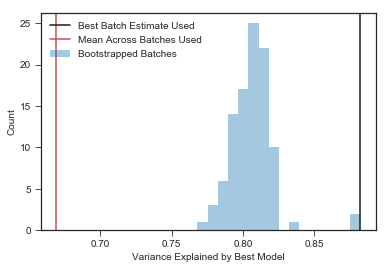

In [252]:
sns.distplot(bests,kde=False,label='Bootstrapped Batches')
plt.axvline(bests[0],color='k',label='Best Batch Estimate Used')
plt.axvline(mean_guess[0],color='r',label='Mean Across Batches Used')
plt.xlabel('Variance Explained by Best Model')
plt.ylabel('Count')
plt.legend()
plt.savefig('bootstrap_predictions_compared_to_mean_nosalt_2components.pdf',bbox_inches='tight')


# plt.figure()
# sns.distplot(ranks)
# plt.axvline(ranks[0],color='k')

1BB_M3
1BB_Baffle
1BB_1.4%Gluc
1BB_1.8%Gluc
1BB_0.2MNaCl
1BB_0.2MKCl
1BB_0.5MKCl
1BB_1%Raf
1BB_0.5%Raf
1BB_1%Gly


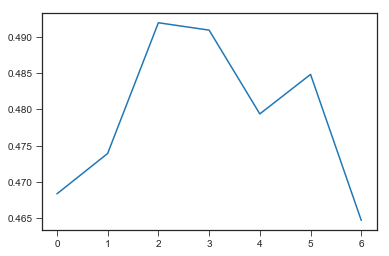

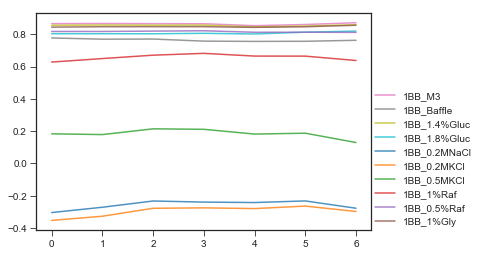

In [160]:
condition_colors = sns.color_palette()
plt.plot(by_rank)
plt.figure()
start = 0
already_plotted = []



for k,condition in enumerate(test_conditions):
    condition = condition.split('_fitness')[0]
    print(condition)
#     condition_name = [name for name, reps in conditions.items() for rep in reps if rep == condition][0]
    condition_name = condition
    index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
    
    index =  index % len(condition_colors)
    if condition_name not in already_plotted:
        plt.plot(by_condition[k],label=condition_name,color=condition_colors[index],alpha=0.8)
        already_plotted.append(condition_name)
    else:
        plt.plot(by_condition[k],color=condition_colors[index],alpha=0.8)
plt.legend(loc=(1.0,0.0))

In [158]:
training_set = this_data[this_data['barcode'].isin(training_bcs)]

minimal_training_bcs = []
for gene in np.unique(training_set['gene'].values):
    this_gene = training_set[training_set['gene']==gene]
    if len(this_gene.values) > 3:
        minimal_training_bcs.append(np.random.choice(this_gene['barcode'].values,3))
    else:
        minimal_training_bcs.append(this_gene['barcode'].values)
    
minimal_training_bcs = tools.flatten(minimal_training_bcs)
minimal_training_bcs =sorted(minimal_training_bcs)

In [ ]:
minimal_training_bcs

1BB_1%Raf
1BB_0.2MNaCl
1BB_0.2MKCl
Resp_5_Day_Transfer
Ferm_50_Hour_Transfer
1.4Glucose
1.7Glucose
Ferm_54_Hour_Transfer
1.8Glucose
1.6Glucose
24_Hour_Transfer_PC
DMSO
Geldanamycin8.5uM
Ferm_44_Hour_Transfer
Ferm_40_Hour_Transfer
Benomyl_2ug/mL
Resp_7_Day_Transfer
Radicicol_5uM
2.5Glucose
Fluconazole_2ug/mL
1BB_0.5MKCl
1BB_1%Raf
1BB_0.2MNaCl
1BB_0.2MKCl
Resp_5_Day_Transfer
Ferm_50_Hour_Transfer
1.4Glucose
1.7Glucose
Ferm_54_Hour_Transfer
1.8Glucose
1.6Glucose
24_Hour_Transfer_PC
DMSO
Geldanamycin8.5uM
Ferm_44_Hour_Transfer
Ferm_40_Hour_Transfer
Benomyl_2ug/mL
Resp_7_Day_Transfer
Radicicol_5uM
2.5Glucose
Fluconazole_2ug/mL
1BB_0.5MKCl


(0, 1)

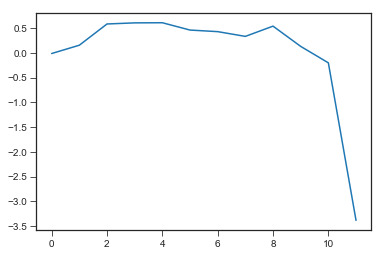

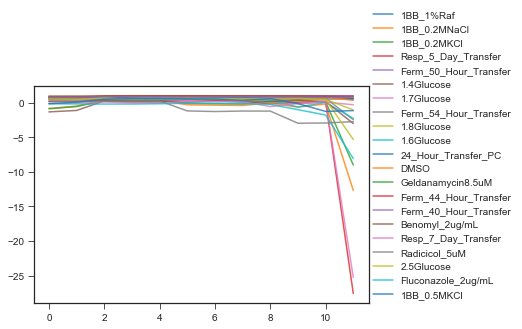

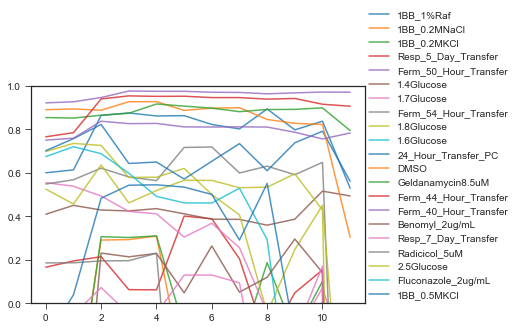

In [30]:

this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

# train_cols = [col + '_fitness' for col in m3_conditions]
# test_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in train_cols]
# test_cols = test_cols + [col + '_fitness' for col in old_nonm3_conditions]
# train_cols = 

fitness_cols = train_cols + test_cols

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

# train_cols = [col+'_original_fitness' for col in [col.split('_')[0] for col in fitness_cols] if col in m3_reps]
# test_cols =  [col+'_original_fitness'  for col in [col.split('_')[0] for col in fitness_cols] if col not in m3_reps]




# fitness_cols = fitness_data.columns

train_conditions = train_cols

# train_conditions = test_cols
train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

test_conditions = test_cols
# test_conditions = train_cols
# test_conditions = [rep for rep in  test_conditions if rep.split('_')[0] in all_reps]
test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]




all_locs = sorted(list(train_locs)+list(test_locs))

this_fitness = fitness[:,all_locs]
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]



train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,minimal_training_bcs))[0]]
test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,minimal_training_bcs))[0]]


by_rank, by_condition, by_mutant, mean_fits, guesses = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=True)
by_condition = np.asarray(by_condition).swapaxes(0,1)

condition_colors = sns.color_palette()
plt.plot(by_rank)
plt.figure()
start = 0
already_plotted = []



for k,condition in enumerate(test_conditions):
    condition = condition.split('_fitness')[0]
    print(condition)
#     condition_name = [name for name, reps in conditions.items() for rep in reps if rep == condition][0]
    condition_name = condition
#     index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
    
    index =  k % len(condition_colors)
    if condition_name not in already_plotted:
        plt.plot(by_condition[k],label=condition_name,color=condition_colors[index],alpha=0.8)
        already_plotted.append(condition_name)
    else:
        plt.plot(by_condition[k],color=condition_colors[index],alpha=0.8)
plt.legend(loc=(1.0,0.0))

plt.figure()
start = 0
already_plotted = []



for k,condition in enumerate(test_conditions):
    condition = condition.split('_fitness')[0]
    print(condition)
#     condition_name = [name for name, reps in conditions.items() for rep in reps if rep == condition][0]
    condition_name = condition
#     index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
    
    index =  k % len(condition_colors)
    if condition_name not in already_plotted:
        plt.plot(by_condition[k],label=condition_name,color=condition_colors[index],alpha=0.8)
        already_plotted.append(condition_name)
    else:
        plt.plot(by_condition[k],color=condition_colors[index],alpha=0.8)
plt.legend(loc=(1.0,0.0))
plt.ylim(0,1)

In [130]:
test_mutant_data = this_data[this_data['barcode'].isin(minimal_test_bcs)]


# this_gene = ['GPB2','PDE2','IRA1','Diploid']
# this
# this_gene_data = test_mutant_data[test_mutant_data['gene'].isin(this_gene)]

this_gene_data = test_mutant_data

# type_list = ['nonsense_variant','frameshift_variant']
# type_list = ['missense_variant']
# this_gene_data = this_gene_data[this_gene_data['type'].isin(type_list)]


this_gene_locs = np.where(np.isin(test_mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[train_conditions[0]].values)) ]

for i,col in enumerate(test_conditions):
    for rank in range(len(guesses)):
        plt.figure()
        plt.title(f'{col} - {rank+1}')
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter(this_gene_data[col].values[bc],guesses[rank][this_gene_locs[bc],i],color=mutant_colorset[this_gene_data['gene'].values[bc]],alpha=0.6)
        
        if rank == 0:
            xmin,xmax = plt.xlim()
            ymin,ymax = plt.ylim()
        plt.xlim(min(xmin,ymin),max(xmax,ymax))
        plt.ylim(min(xmin,ymin),max(xmax,ymax))
        plt.tight_layout()
        plt.plot([min(xmin,ymin),max(xmax,ymax)],[min(xmin,ymin),max(xmax,ymax)],'k--')
        plt.gca().set_aspect('equal')
        plt.xlabel('Measured Fitness')
        plt.ylabel('Predicted Fitness')
        plt.savefig(f'predictions_by_gene_sidebyside_minimaltraining_{col.replace("/","")}_{rank+1}components_lims.pdf',bbox_inches='tight')

NameError: name 'minimal_test_bcs' is not defined

In [45]:
np.where(((guesses[0]-test_measured)/test_measured)==np.max(((guesses[0]-test_measured)/test_measured)))

(array([30]), array([2]))

In [129]:

mean_guess = []
for i,col in enumerate(test_conditions):

    mean_guess.append(tools.var_explained(this_fitness[test_mutants,:][:,new_test_locs[i]],
                                          np.repeat(np.mean(this_fitness[test_mutants,:][:,new_train_locs],axis=1),1).reshape(len(test_mutants),1)))



NameError: name 'test_mutants' is not defined

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


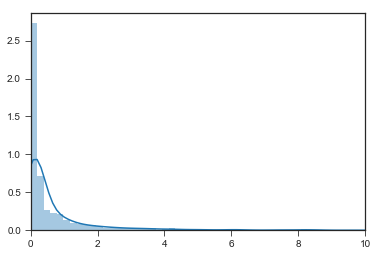

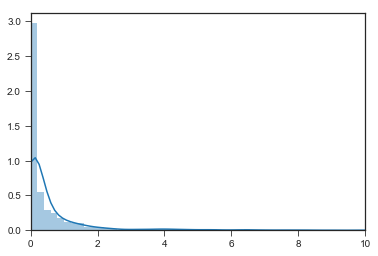

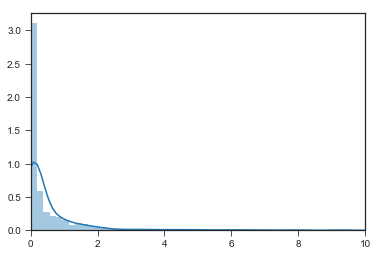

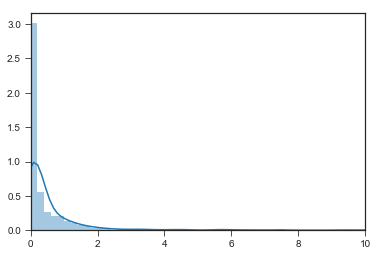

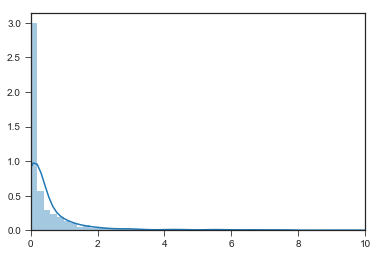

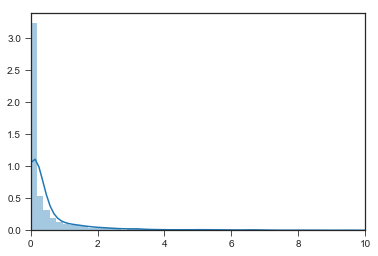

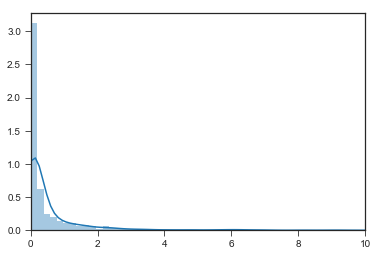

In [55]:
for rank in range(len(guesses)):
    plt.figure()
    sns.distplot([x for x in np.abs((guesses[rank]-test_measured)/test_measured).flatten() if x < 10])
    plt.xlim(0,10)

In [52]:
gene_locs = {}

altered_data=copy.copy(this_data)

new_genes = []
for bc in range(len(this_data['barcode'].values)):
    gene = this_data['gene'].values[bc]
    print(gene,len(this_data[this_data['gene']==gene].values))
    if len(this_data[this_data['gene']==gene].values) < 4:
        new_genes.append('other')
    else:
        new_genes.append(gene)

altered_data['gene'] = new_genes

for gene in np.unique(altered_data['gene'].values):
    this_gene = np.where(np.isin(altered_data['barcode'].values,altered_data[altered_data['gene']==gene]['barcode'].values))[0]
    gene_locs[gene] = np.where(np.isin(test[1],this_gene))[0]

Diploid 139
IRA1 25
NotSequenced 32
IRA1 25
NotSequenced 32
IRA1 25
NotSequenced 32
NotSequenced 32
NotSequenced 32
Diploid 139
PDE2 11
other 51
other 51
PDE2 11
Diploid 139
Diploid + IRA2 3
GPB2 13
IRA2 7
GPB1 4
GPB2 13
Diploid 139
Diploid 139
Diploid + IRA2 3
IRA1 25
NotSequenced 32
Diploid 139
Diploid 139
Diploid 139
Diploid 139
IRA1 25
Diploid + IRA2 3
PDE2 11
PDE2 11
Diploid + Chr11Amp 2
IRA2 7
NotSequenced 32
Diploid 139
other 51
Diploid 139
GPB2 13
GPB2 13
IRA1 25
other 51
IRA1 25
PDE2 11
CYR1 3
Diploid 139
other 51
NotSequenced 32
Diploid 139
Diploid 139
IRA1 25
GPB2 13
Diploid + IRA1 1
other 51
Diploid 139
GPB2 13
RAS2 1
IRA1 25
GPB2 13
Diploid 139
Diploid 139
Diploid 139
IRA1 25
other 51
Diploid 139
Diploid 139
GPB2 13
NotSequenced 32
Diploid 139
Diploid 139
IRA1 25
IRA1 25
Diploid 139
PDE2 11
NotSequenced 32
other 51
GPB2 13
other 51
IRA2 7
Diploid 139
IRA1 25
NotSequenced 32
PDE2 11
IRA1 25
Diploid 139
Diploid 139
Diploid 139
other 51
other 51
IRA1 25
PDE2 11
TOR1 1
Diploid

In [53]:
gene_locs

{'Diploid': array([11, 16, 20, 21, 22, 26, 31, 34, 35, 40, 45, 48, 49, 52, 53, 56, 63,
        68, 69, 75, 78, 80]),
 'GPB1': array([], dtype=int64),
 'GPB2': array([13, 15, 27, 37, 41, 44, 50, 60, 81]),
 'IRA1': array([ 0,  2,  4, 18, 23, 28, 30, 36, 43, 46, 54, 55, 64, 67, 72, 77, 82]),
 'IRA2': array([14, 24, 62, 76]),
 'NotSequenced': array([ 1,  3,  5,  6, 19, 25, 33, 51, 58, 65, 79]),
 'PDE2': array([ 7, 10, 57, 66, 73]),
 'other': array([ 8,  9, 12, 17, 29, 32, 38, 39, 42, 47, 59, 61, 70, 71, 74])}

In [114]:
cutoff = 10

test_measured = this_fitness[test[1],:][:,test[0]]

devs = np.abs((guesses[0]-test_measured)/test_measured)
devs[devs > cutoff] = np.nan

mean_gene = []
for gene in gene_locs:
    mean_gene.append((np.nanmean(np.nanmean(devs,axis=1)[gene_locs[gene]]),gene))
sorted_mean_gene = sorted(mean_gene)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


In [115]:
mutant_sort = []
gene_names = []
for val,gene in sorted_mean_gene:
    gene_names.append((gene,len(gene_locs[gene])))
    mutant_sort.append(gene_locs[gene][np.argsort(np.nanmean(devs,axis=1)[gene_locs[gene]])])
mutant_sort = tools.flatten(mutant_sort)    

In [126]:
by_condition

array([[-2.44487037e-01,  1.85800323e-01, -6.47971214e-01,
        -1.05958622e+00, -9.65888055e-01, -1.22360750e+00,
        -1.16071981e+00,  3.12377219e-01,  5.09225691e-02,
        -1.59022731e+00, -3.99520515e+00, -5.88827451e+00,
        -7.08297047e+00],
       [-2.99981750e-01,  2.27589536e-01, -5.85098724e-01,
        -9.45394940e-01, -8.44110607e-01, -1.10820516e+00,
        -8.77768875e-01, -1.20263722e-01, -5.26732268e-01,
        -1.79718712e+00, -4.25737160e+00, -5.84834876e+00,
        -1.00523932e+01],
       [ 2.12628969e-01,  2.01665152e-01, -2.55770628e-01,
        -8.98833820e-01, -8.70909442e-01, -1.07411070e+00,
        -7.25408810e-01,  8.40143738e-02,  1.37230292e-01,
        -2.44090509e-01, -6.50358649e-01, -3.72884182e+00,
        -6.82299788e-01],
       [ 8.56015422e-01,  8.82851647e-01,  8.91541234e-01,
         9.47641555e-01,  9.54262171e-01,  9.55045445e-01,
         9.55144598e-01,  9.32200443e-01,  9.34420599e-01,
         9.56209268e-01,  9.47244904e

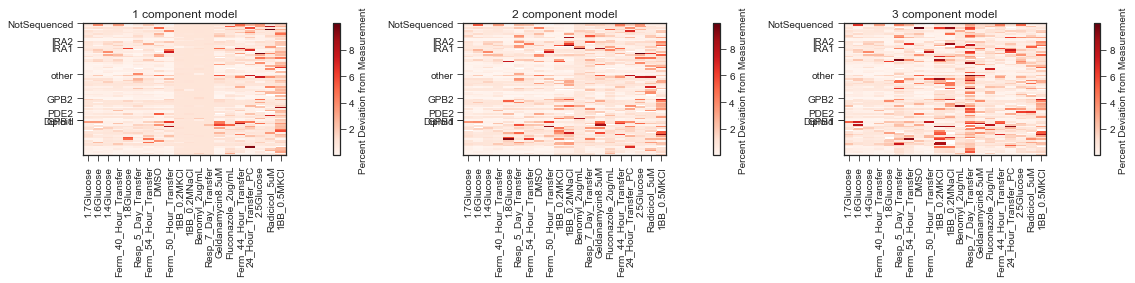

In [118]:
cutoff = 10

test_measured = this_fitness[test[1],:][:,test[0]]

devs = np.abs((guesses[0]-test_measured)/test_measured)
devs[devs > cutoff] = np.nan

# mutant_sort = np.argsort(np.nanmean(devs,axis=1))
condition_sort = np.argsort(np.nanmean(devs,axis=0))


fig = plt.figure(figsize=(4*4,4*1))
for rank in range(3):

    devs = np.abs((guesses[rank]-test_measured)/test_measured)
    devs[devs > cutoff] = np.nan
    
    
    
    sorted_devs = devs[mutant_sort,:][:,condition_sort]


    plt.subplot(1,3,rank+1)
    plt.title(f'{rank+1} component model')
    pcm = plt.pcolormesh(sorted_devs,cmap='Reds')
    cbar = fig.colorbar(pcm,pad=0.16)
    cbar.set_label('Percent Deviation from Measurement')
    
    plt.xticks([i+0.5 for i in range(len(test_cols))],[col.split('_fitness')[0] for col in np.asarray(test_cols)[condition_sort]],rotation=90)
    
    plt.yticks(np.cumsum([i for (g,i) in gene_names]),[g for (g,i) in gene_names])
    
plt.tight_layout()
# plt.savefig(f'prediction_heatmap_allranks_cutoff{cutoff}_witholddat_minimaltraining.pdf',bbox_inches='tight')
                                                           

([<matplotlib.axis.XTick at 0x156a0c320>,
 <a list of 20 Text xticklabel objects>)

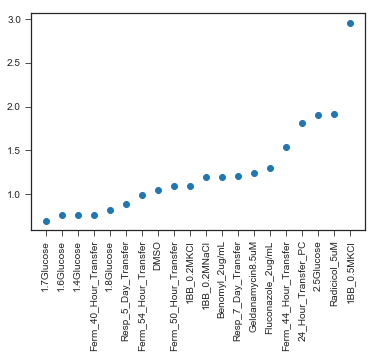

In [123]:
plt.plot(sorted(np.nanmean(devs,axis=0)),'o')
plt.xticks([i for i in range(len(test_cols))],[col.split('_fitness')[0] for col in np.asarray(test_cols)[condition_sort]],rotation=90)



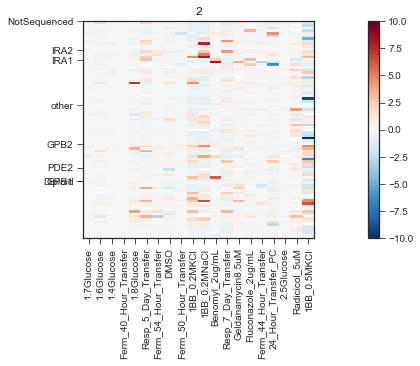

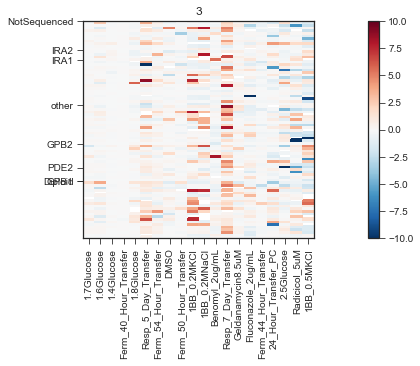

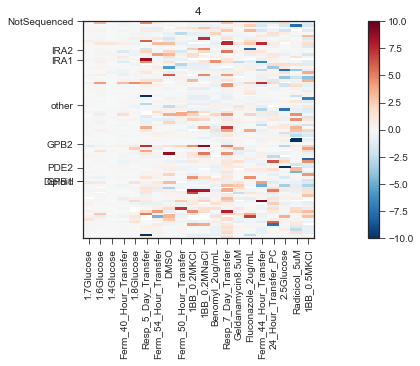

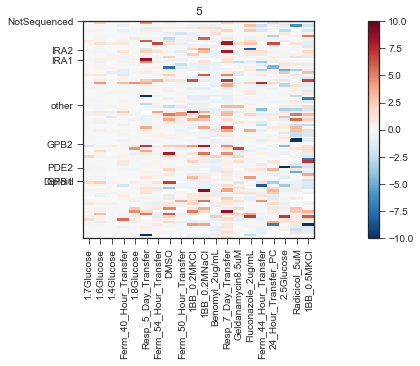

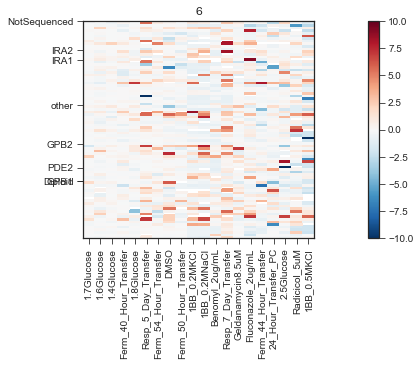

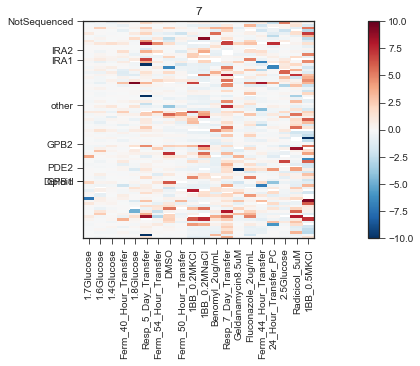

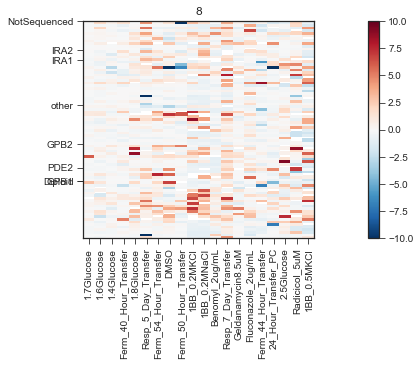

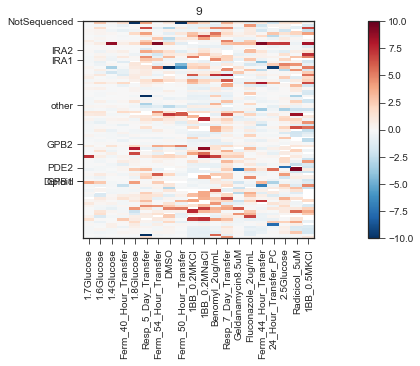

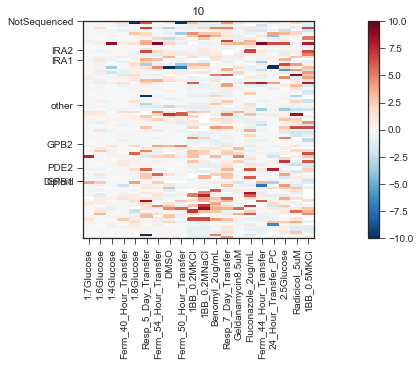

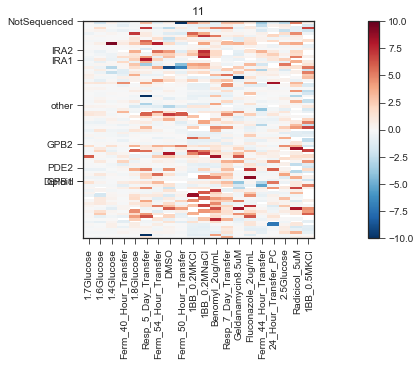

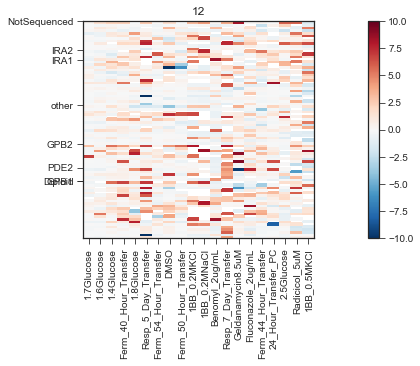

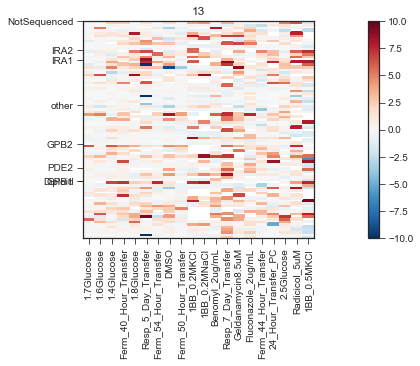

In [125]:
cutoff = 10

test_measured = this_fitness[test[1],:][:,test[0]]

devs0 = np.abs((guesses[0]-test_measured)/test_measured)
devs0[devs0 > cutoff] = np.nan

# mutant_sort = np.argsort(np.nanmean(devs,axis=1))
condition_sort = np.argsort(np.nanmean(devs0,axis=0))

for rank in range(1,len(guesses)):

    devs = np.abs((guesses[rank]-test_measured)/test_measured)
    devs[devs > cutoff] = np.nan
    devs = devs - np.abs((guesses[0]-test_measured)/test_measured)
    
    
    
    sorted_devs = devs[mutant_sort,:][:,condition_sort]


    fig = plt.figure()
    plt.title(rank+1)
    pcm = plt.pcolormesh(sorted_devs,cmap='RdBu_r', vmin=-10, vmax=10)
    cbar = fig.colorbar(pcm,pad=0.16)
    plt.xticks([i+0.5 for i in range(len(test_cols))],[col.split('_fitness')[0] for col in np.asarray(test_cols)[condition_sort]],rotation=90)
    plt.yticks(np.cumsum([i for (g,i) in gene_names]),[g for (g,i) in gene_names])                

In [66]:
train_cols

['18_fitness',
 '1BB_M3_fitness',
 '21_fitness',
 '23_fitness',
 '20_fitness',
 '3_fitness',
 '13_fitness',
 '1BB_1.4%Gluc_fitness',
 '1BB_1.8%Gluc_fitness',
 '1BB_1%Gly_fitness',
 '1BB_Baffle_fitness',
 '1BB_0.5%Raf_fitness']

In [67]:
test_cols

['1BB_1%Raf_fitness',
 '1BB_0.2MNaCl_fitness',
 '1BB_0.2MKCl_fitness',
 'Resp_5_Day_Transfer_fitness',
 'Ferm_50_Hour_Transfer_fitness',
 '1.4Glucose_fitness',
 '1.7Glucose_fitness',
 'Ferm_54_Hour_Transfer_fitness',
 '1.8Glucose_fitness',
 '1.6Glucose_fitness',
 '24_Hour_Transfer_PC_fitness',
 'DMSO_fitness',
 'Geldanamycin8.5uM_fitness',
 'Ferm_44_Hour_Transfer_fitness',
 'Ferm_40_Hour_Transfer_fitness',
 'Benomyl_2ug/mL_fitness',
 'Resp_7_Day_Transfer_fitness',
 'Radicicol_5uM_fitness',
 '2.5Glucose_fitness',
 'Fluconazole_2ug/mL_fitness',
 '1BB_0.5MKCl_fitness']

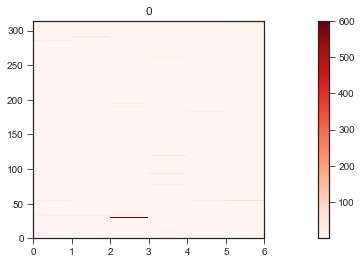

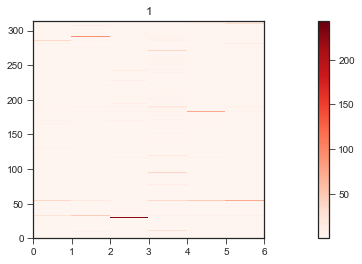

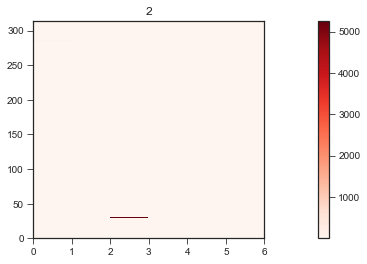

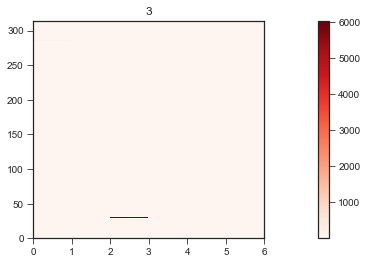

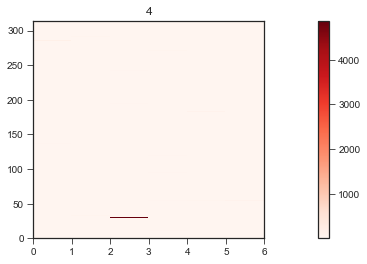

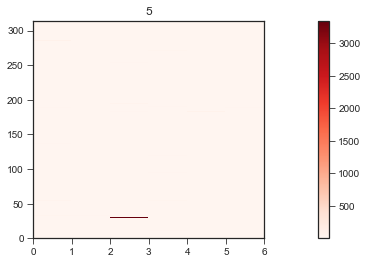

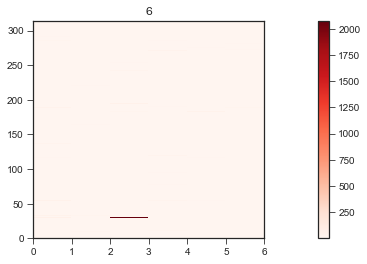

In [42]:
test_measured = this_fitness[test[1],:][:,test[0]]

removals = [42]

pared_guesses = [guesses[rank][w] for rank in range(len(guesses))]
 
for rank in range(len(guesses)):
    fig = plt.figure()
    plt.title(rank)
    pcm = plt.pcolormesh(np.abs((guesses[rank]-test_measured)/test_measured),cmap='Reds')
    cbar = fig.colorbar(pcm,pad=0.16)

1BB_Baffle
1BB_1.4%Gluc
1BB_1.8%Gluc
1BB_0.2MNaCl
1BB_0.2MKCl
1BB_0.5MKCl
1BB_1%Raf
1BB_0.5%Raf
1BB_1%Gly


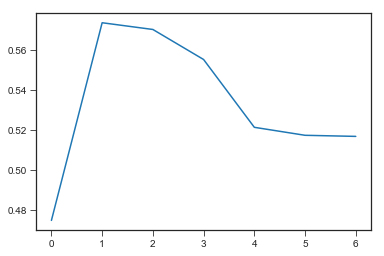

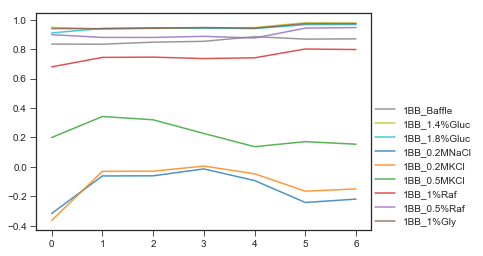

In [64]:

train_conditions = train_cols
# train_conditions = test_cols
train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

test_conditions = test_cols
# test_conditions = train_cols
# test_conditions = [rep for rep in  test_conditions if rep.split('_')[0] in all_reps]
test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]




all_locs = sorted(list(train_locs)+list(test_locs))

this_fitness = fitness[:,all_locs]
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]



train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]


by_rank, by_condition, by_mutant, mean_fits, guesses = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=True)
by_condition = np.asarray(by_condition).swapaxes(0,1)

condition_colors = sns.color_palette()
plt.plot(by_rank)
plt.figure()
start = 0
already_plotted = []



for k,condition in enumerate(test_conditions):
    condition = condition.split('_fitness')[0]
    print(condition)
#     condition_name = [name for name, reps in conditions.items() for rep in reps if rep == condition][0]
    condition_name = condition
    index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
    
    index =  index % len(condition_colors)
    if condition_name not in already_plotted:
        plt.plot(by_condition[k],label=condition_name,color=condition_colors[index],alpha=0.8)
        already_plotted.append(condition_name)
    else:
        plt.plot(by_condition[k],color=condition_colors[index],alpha=0.8)
plt.legend(loc=(1.0,0.0))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x11e0479e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x11e1cc3c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x11ec3a9b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning:

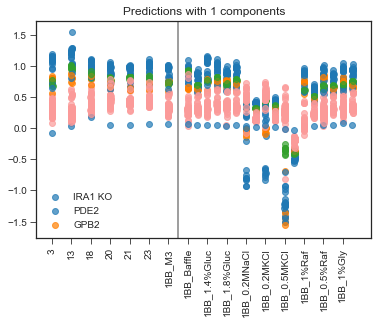

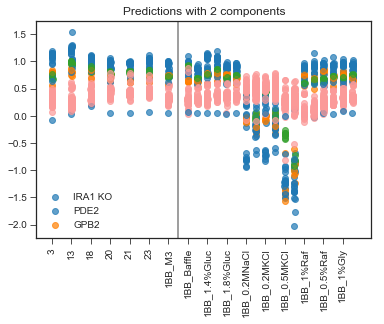

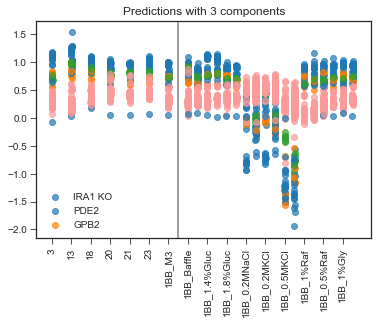

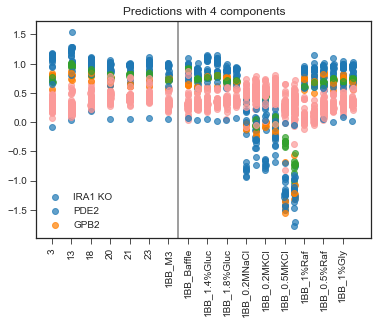

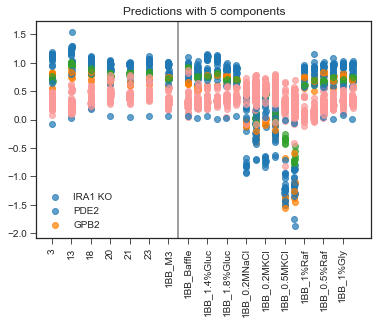

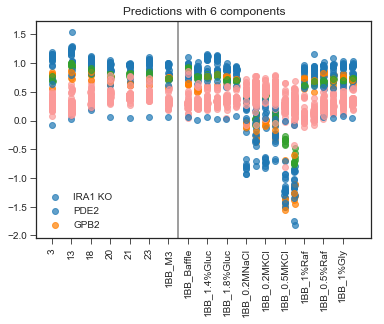

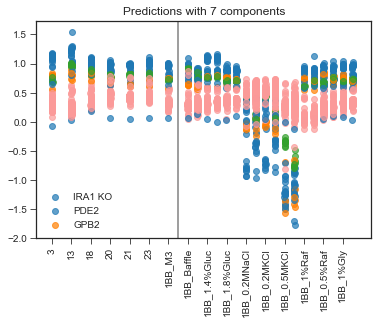

In [57]:
test_mutant_data = this_data[~this_data['barcode'].isin(training_bcs)]


this_gene = ['GPB2','PDE2','IRA1','Diploid']
# this
this_gene_data = test_mutant_data[test_mutant_data['gene'].isin(this_gene)]

# type_list = ['nonsense_variant','frameshift_variant']
# type_list = ['missense_variant']
# this_gene_data = this_gene_data[this_gene_data['type'].isin(type_list)]


this_gene_locs = np.where(np.isin(test_mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[train_conditions[0]].values)) ]

for rank in range(7):
    plt.figure()
    plt.title(f'Predictions with {rank+1} components')
    for i,col in enumerate(train_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    for i,col in enumerate(test_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([len(train_conditions)+i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    plt.gca().set_prop_cycle(None)
    for i,col in enumerate(test_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([len(train_conditions)+i + 1 + 0.5 + jitters[bc]],guesses[rank][this_gene_locs[bc],i],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
#     sns.boxplot(data=guesses[rank][this_gene_locs,:])
    
    plt.axvline(x=len(train_conditions)+0.5,color='gray')
    plt.legend(['_nolegend_','IRA1 KO','PDE2','_nolegend_','GPB2'])
    plt.xticks(range(1,len(train_conditions)+len(test_conditions)+1),[col.split('_fitness')[0] for col in (train_conditions + test_conditions)],rotation=90)
    
    
#     plt.savefig('predictions_by_gene_{rank+1}components.pdf',bbox_inches='tight')

In [ ]:
test_mutant_data = this_data[~this_data['barcode'].isin(minimal_training_bcs)]


# this_gene = ['GPB2','PDE2','IRA1','Diploid']
# this
# this_gene_data = test_mutant_data[test_mutant_data['gene'].isin(this_gene)]

this_gene_data = test_mutant_data

# type_list = ['nonsense_variant','frameshift_variant']
# type_list = ['missense_variant']
# this_gene_data = this_gene_data[this_gene_data['type'].isin(type_list)]


this_gene_locs = np.where(np.isin(test_mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[train_conditions[0]].values)) ]

for i,col in enumerate(test_conditions):
    for rank in range(len(guesses)):
        plt.figure()
        plt.title(f'{col} - {rank+1}')
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter(this_gene_data[col].values[bc],guesses[rank][this_gene_locs[bc],i],color=mutant_colorset[this_gene_data['gene'].values[bc]],alpha=0.6)
        
        xmin,xmax = plt.xlim()
        ymin,ymax = plt.ylim()
        plt.xlim(min(xmin,ymin),max(xmax,ymax))
        plt.ylim(min(xmin,ymin),max(xmax,ymax))
        plt.tight_layout()
        plt.gca().set_aspect('equal')
        plt.xlabel('Measured Fitness')
        plt.ylabel('Predicted Fitness')
        plt.savefig(f'predictions_by_gene_sidebyside_withold_minimalmutants_{col}_{rank+1}components.pdf',bbox_inches='tight')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

In [74]:
this_data[this_data['barcode']==this_data['barcode'].values[55]][train_conditions+test_conditions].values

array([[-0.0797669 ,  0.01417236, -0.05644245, -0.05836564, -0.04170214,
        -0.02043665,  0.00849465, -0.01985987,  0.03937098,  0.01264094,
         0.06193405,  0.00542039, -0.01789558,  0.03744408, -0.05614371,
        -0.02542603]])

In [85]:
this_data[this_data['class'].isin(['ExpNeutral'])]

,barcode,gene,type,ploidy,class,additional_muts,13.1_T1to2_error,13.1_T1to2_fitness,13.1_T2to3_error,13.1_T2to3_fitness,...,D.DE1.PCRb.1-D.DE1.PCRb.2_error,D.DE1.PCRb.1-D.DE1.PCRb.2_fitness,D.DE1.PCRb.2-D.DE1.PCRa.3_error,D.DE1.PCRb.2-D.DE1.PCRa.3_fitness,D.DE1.PCRb.2-D.DE1.PCRb.3_error,D.DE1.PCRb.2-D.DE1.PCRb.3_fitness,D.DE1.PCRb.3-D.DE1.PCRa.4_error,D.DE1.PCRb.3-D.DE1.PCRa.4_fitness,D.DE1.PCRb.3-D.DE1.PCRb.4_error,D.DE1.PCRb.3-D.DE1.PCRb.4_fitness
292,72939,NotSequenced,NotSequenced,NotSequenced,ExpNeutral,NotSequenced,1.0,0.058130,1.0,0.044166,...,1.0,-0.106077,1.0,0.104692,1.0,0.231084,1.0,-0.064463,1.0,-0.038010
357,120600,other,other,other,ExpNeutral,nan-upstream_indel_variant,1.0,-0.022603,1.0,-0.036836,...,1.0,0.085671,1.0,-0.262471,1.0,-0.011153,1.0,-0.074272,1.0,0.052239
474,298344,other,other,other,ExpNeutral,FYV10-upstream_indel_variant; YKL177W-upstream...,1.0,-0.190787,1.0,0.170166,...,1.0,-0.140856,1.0,0.389522,1.0,0.212395,1.0,0.038669,1.0,-0.012900


In [88]:
this_data[this_data['gene']=='other']

,barcode,gene,type,ploidy,class,additional_muts,13.1_T1to2_error,13.1_T1to2_fitness,13.1_T2to3_error,13.1_T2to3_fitness,...,D.DE1.PCRb.1-D.DE1.PCRb.2_error,D.DE1.PCRb.1-D.DE1.PCRb.2_fitness,D.DE1.PCRb.2-D.DE1.PCRa.3_error,D.DE1.PCRb.2-D.DE1.PCRa.3_fitness,D.DE1.PCRb.2-D.DE1.PCRb.3_error,D.DE1.PCRb.2-D.DE1.PCRb.3_fitness,D.DE1.PCRb.3-D.DE1.PCRa.4_error,D.DE1.PCRb.3-D.DE1.PCRa.4_fitness,D.DE1.PCRb.3-D.DE1.PCRb.4_error,D.DE1.PCRb.3-D.DE1.PCRb.4_fitness
16,1641,other,other,other,other,nan-nan,1.0,0.183488,1.0,0.055235,...,1.0,-0.174079,1.0,0.107723,1.0,0.094027,1.0,0.094105,1.0,0.199129
17,1683,other,other,other,other,SDH3-upstream_point_variant; MFM1-missense_var...,1.0,0.092495,1.0,-0.178251,...,1.0,-0.023457,1.0,0.090384,1.0,-0.103985,1.0,0.236495,1.0,0.245908
53,7291,other,other,other,other,"IMP4-missense_variant; YER156C,COG3-upstream_i...",1.0,-0.122278,1.0,0.003392,...,1.0,-0.036893,1.0,0.058277,1.0,0.066181,1.0,0.085515,1.0,-0.120820
56,7538,other,other,other,other,SEC31-synonymous_variant; ERG1-missense_varian...,1.0,0.892983,1.0,0.598109,...,1.0,-0.038893,1.0,-0.197483,1.0,0.066257,1.0,-0.039292,1.0,0.147415
62,7953,other,other,other,other,nan-nan,1.0,1.212985,1.0,1.076551,...,1.0,0.806385,1.0,0.891071,1.0,0.653368,1.0,0.732599,1.0,0.802753
68,8825,other,other,other,other,ATG32-upstream_indel_variant,1.0,-0.003088,1.0,-0.126550,...,1.0,-0.193931,1.0,-0.214006,1.0,0.232056,1.0,0.032620,1.0,-0.076126
77,10307,other,other,other,other,nan-nan,1.0,0.151889,1.0,0.080794,...,1.0,-0.160825,1.0,0.162019,1.0,-0.236642,1.0,0.114391,1.0,0.064709
97,13183,other,other,other,other,nan-nan,1.0,1.418840,1.0,1.330550,...,1.0,0.102428,1.0,-0.224542,1.0,-0.175302,1.0,0.017579,1.0,0.090621
113,17499,other,other,other,other,LCP5-upstream_indel_variant; PTC3-synonymous_v...,1.0,-0.169470,1.0,0.444566,...,1.0,-0.099572,1.0,-0.256100,1.0,0.047418,1.0,0.251171,1.0,0.008007
117,18152,other,other,other,other,KTI12-missense_variant,1.0,1.436099,1.0,1.338601,...,1.0,0.930502,1.0,1.074372,1.0,1.115791,1.0,0.934102,1.0,0.920605


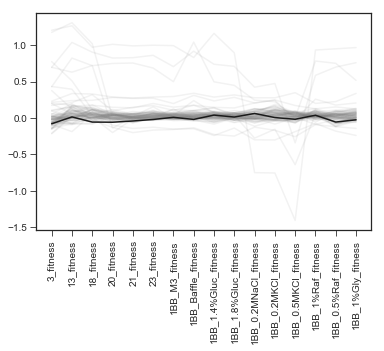

In [91]:
# np.where(guesses[1][:,6] > 1.5)
for bc in this_data[this_data['gene']=='other']['barcode'].values:
    plt.plot(this_data[this_data['barcode']==bc][train_conditions+test_conditions].values[0],color='gray',alpha=0.1)




# for bc in neutrals:
#     if bc in this_data['barcode'].values:
#         plt.plot(this_data[this_data['barcode']==bc][train_conditions+test_conditions].values[0],color='gray')

plt.plot(this_data[this_data['barcode']==this_data['barcode'].values[55]][train_conditions+test_conditions].values[0],color='k')
plt.xticks(range(len(train_conditions+test_conditions)),train_conditions+test_conditions,rotation=90)
plt.savefig('weirdly_predicted_neutral_Raffionse.pdf',bbox_inches='tight')

In [53]:
test_mutant_data = this_data[~this_data['barcode'].isin(training_bcs)]


this_gene = ['GPB2','PDE2','IRA1']
# this
this_gene_data = test_mutant_data[test_mutant_data['gene'].isin(this_gene)]

type_list = ['nonsense_variant','frameshift_variant']
# type_list = ['missense_variant']
this_gene_data = this_gene_data[this_gene_data['type'].isin(type_list)]


this_gene_locs = np.where(np.isin(test_mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[col].values)) ]

for rank in range(7):
    plt.figure()
    plt.title(f'Predictions with {rank+1} components')
    for i,col in enumerate(train_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    for i,col in enumerate(test_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([len(train_conditions)+i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    plt.gca().set_prop_cycle(None)
#     for i,col in enumerate(test_conditions):
#         for bc in range(len(this_gene_data[col].values)):
#             plt.scatter([len(train_conditions)+i + 1 + 0.5 + jitters[bc]],guesses[rank][this_gene_locs[bc],i],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    sns.boxplot(data=guesses[rank][this_gene_locs,:])
    
    plt.axvline(x=len(train_conditions)+0.5,color='gray')
    plt.legend(['_nolegend_','IRA1 KO','PDE2','_nolegend_','GPB2'])
    plt.xticks(range(1,len(train_conditions)+len(test_conditions)+1),[col.split('_fitness')[0] for col in (train_conditions + test_conditions)],rotation=90)
    
    
#     plt.savefig('predictions_by_gene_{rank+1}components.pdf',bbox_inches='tight')

NameError: name 'col' is not defined

1BB_Baffle
1BB_1.4%Gluc
1BB_1.8%Gluc
1BB_0.2MNaCl
1BB_0.2MKCl
1BB_0.5MKCl
1BB_1%Raf
1BB_0.5%Raf
1BB_1%Gly


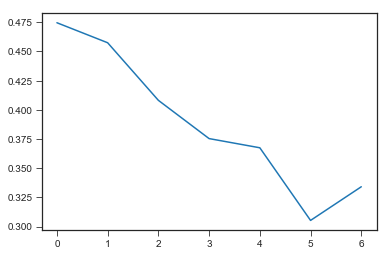

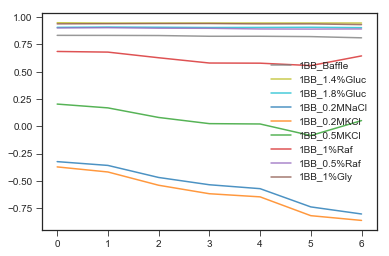

In [96]:

train_conditions = train_cols
# train_conditions = test_cols
train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

test_conditions = test_cols
# test_conditions = train_cols
# test_conditions = [rep for rep in  test_conditions if rep.split('_')[0] in all_reps]
test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]




all_locs = sorted(list(train_locs)+list(test_locs))

this_fitness = fitness[:,all_locs]
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]



train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]


by_rank, by_condition, by_mutant, mean_fits, guesses = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=True,permuted_mutants=True)
by_condition = np.asarray(by_condition).swapaxes(0,1)

condition_colors = sns.color_palette()
plt.plot(by_rank)
plt.figure()
start = 0
already_plotted = []



for k,condition in enumerate(test_conditions):
    condition = condition.split('_fitness')[0]
    print(condition)
#     condition_name = [name for name, reps in conditions.items() for rep in reps if rep == condition][0]
    condition_name = condition
    index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
    
    index =  index % len(condition_colors)
    if condition_name not in already_plotted:
        plt.plot(by_condition[k],label=condition_name,color=condition_colors[index],alpha=0.8)
        already_plotted.append(condition_name)
    else:
        plt.plot(by_condition[k],color=condition_colors[index],alpha=0.8)
plt.legend()

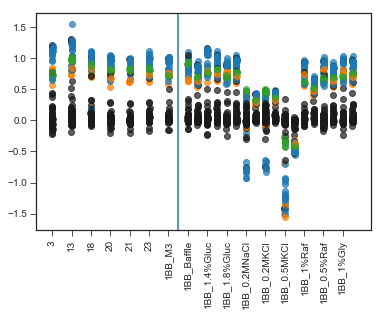

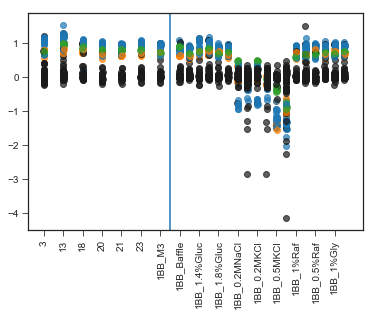

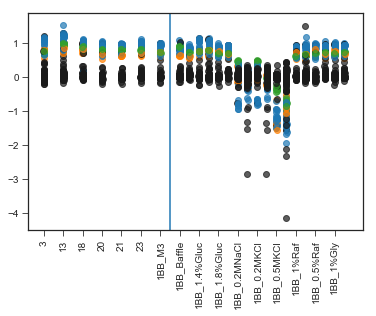

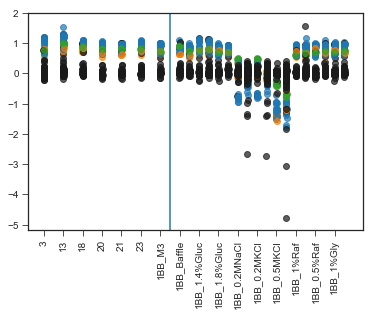

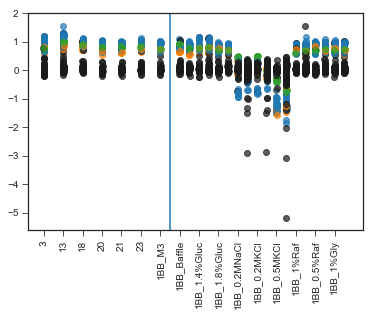

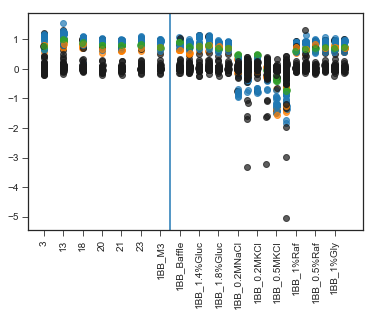

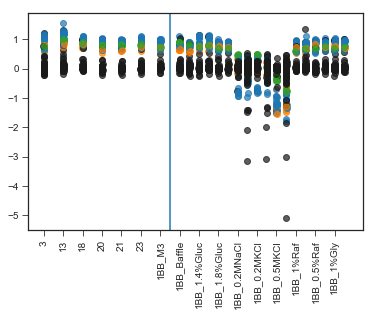

In [215]:
test_mutant_data = this_data[~this_data['barcode'].isin(training_bcs)]


this_gene = ['GPB2','PDE2','IRA1','other']
this_gene_data = test_mutant_data[test_mutant_data['gene'].isin(this_gene)]

# type_list = ['nonsense_variant','frameshift_variant']
# type_list = ['missense_variant']
# this_gene_data = this_gene_data[this_gene_data['type'].isin(type_list)]


this_gene_locs = np.where(np.isin(test_mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[col].values)) ]

for rank in range(7):
    plt.figure()
    for i,col in enumerate(train_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    for i,col in enumerate(test_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([len(train_conditions)+i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    plt.gca().set_prop_cycle(None)
    for i,col in enumerate(test_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([len(train_conditions)+i + 1 + 0.5 + jitters[bc]],guesses[rank][this_gene_locs[bc],i],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
#     plt.boxplot(guesses[rank][this_gene_locs,:])
    plt.axvline(x=len(train_conditions)+0.5)
    plt.xticks(range(1,len(train_conditions)+len(test_conditions)+1),[col.split('_fitness')[0] for col in (train_conditions + test_conditions)],rotation=90)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


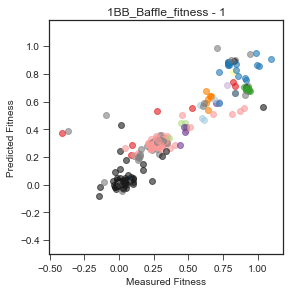

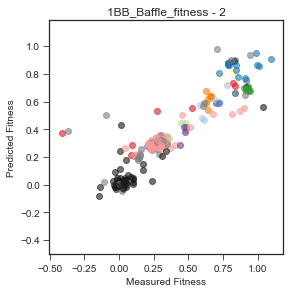

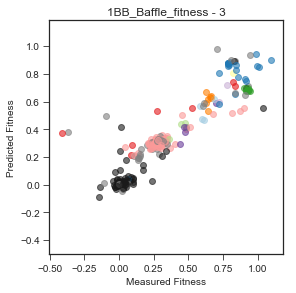

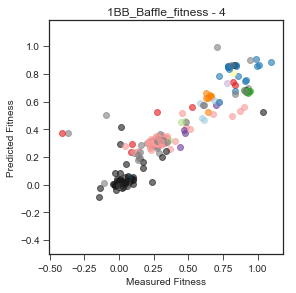

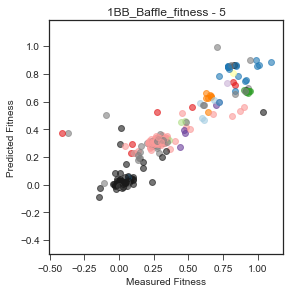

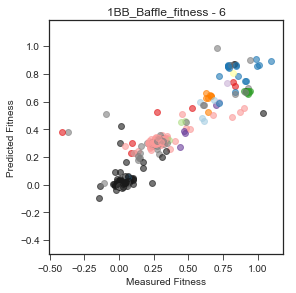

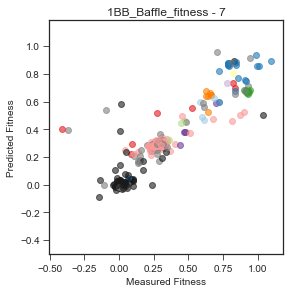

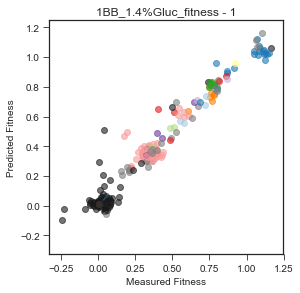

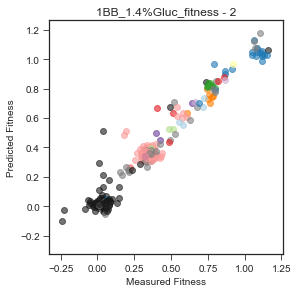

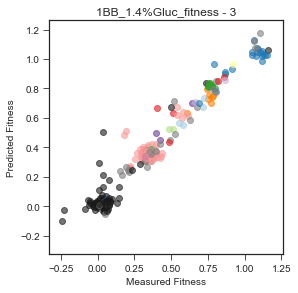

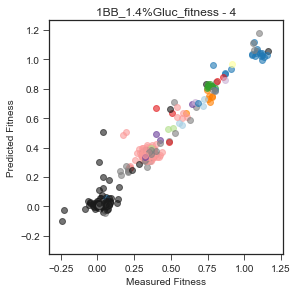

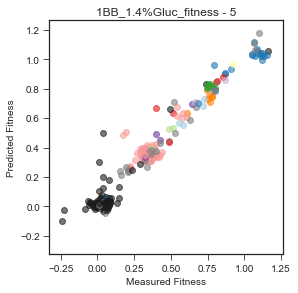

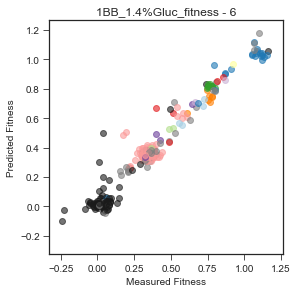

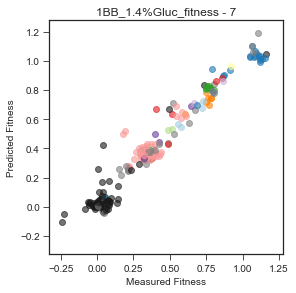

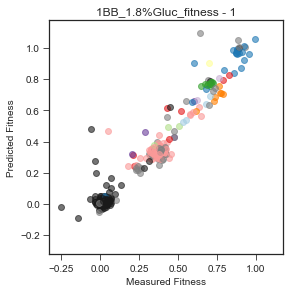

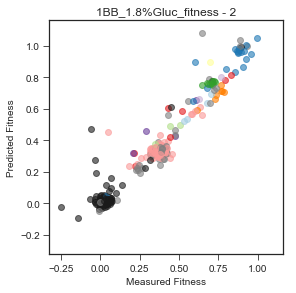

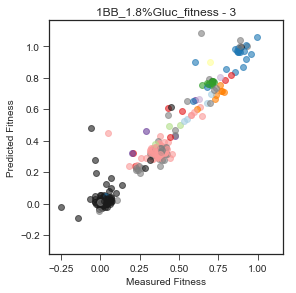

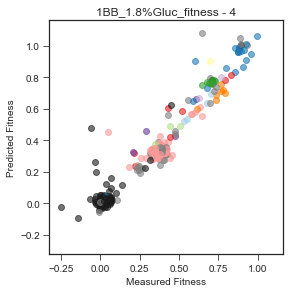

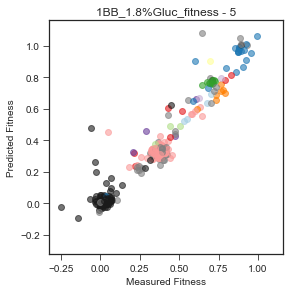

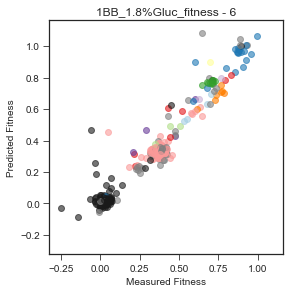

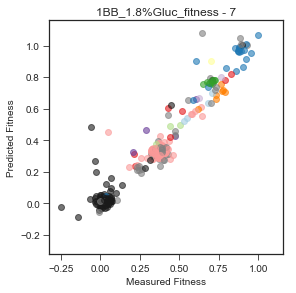

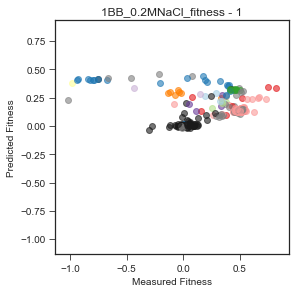

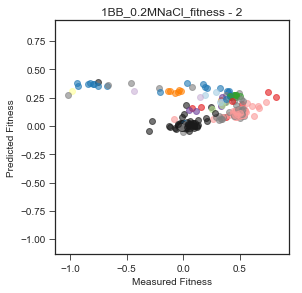

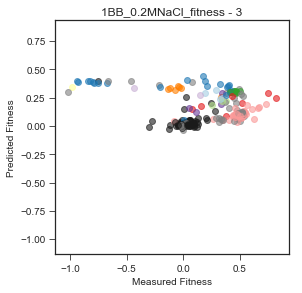

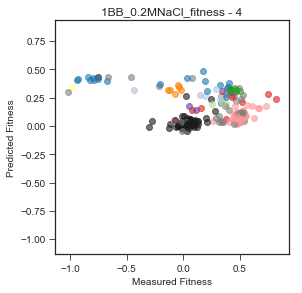

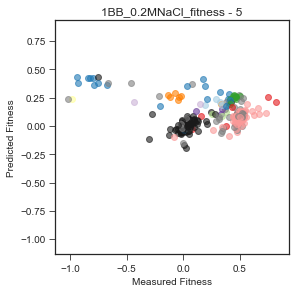

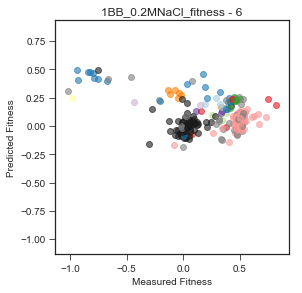

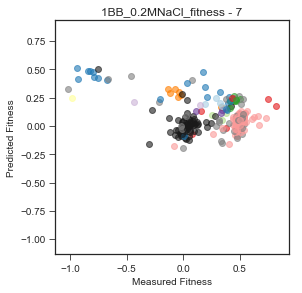

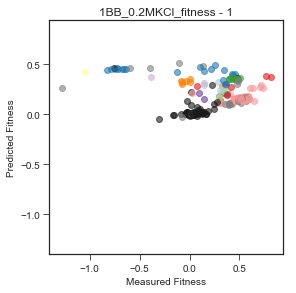

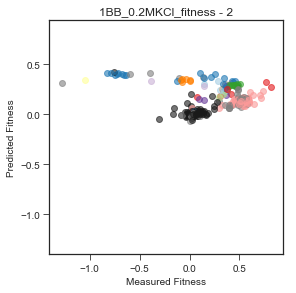

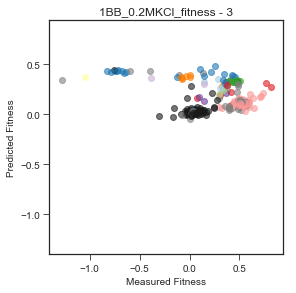

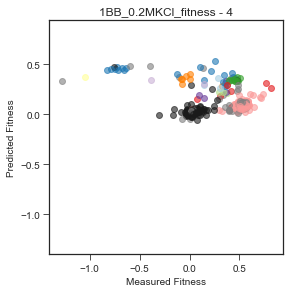

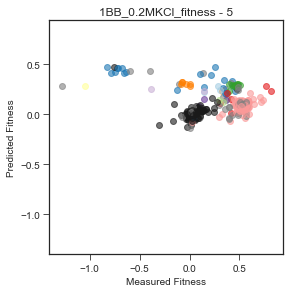

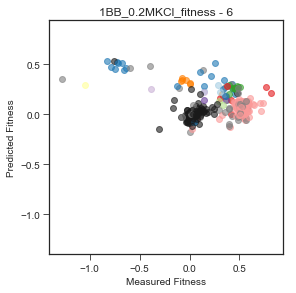

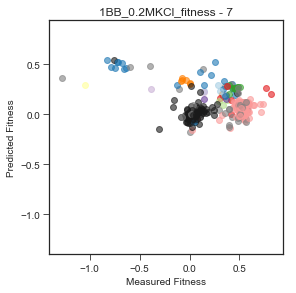

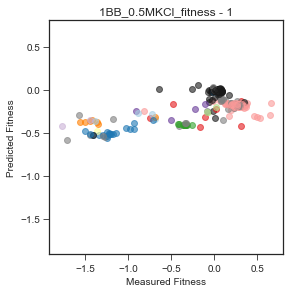

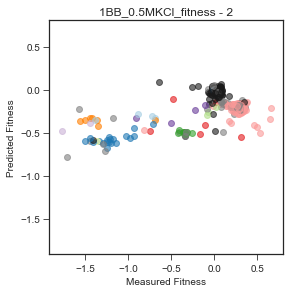

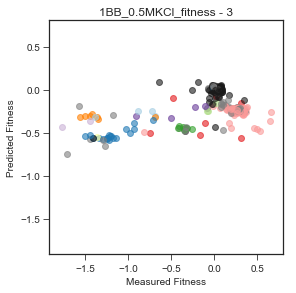

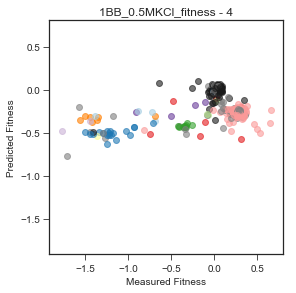

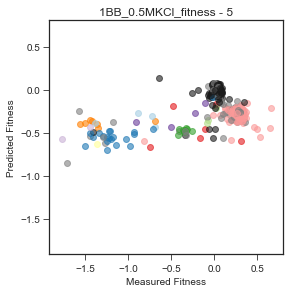

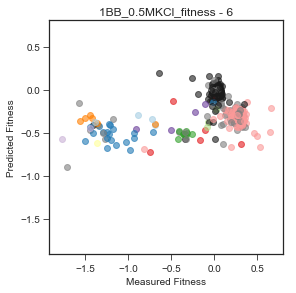

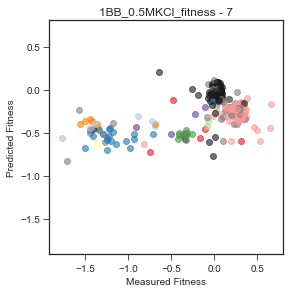

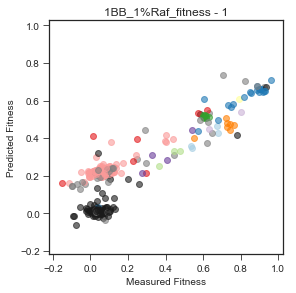

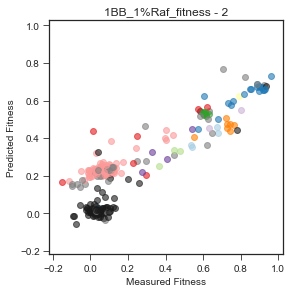

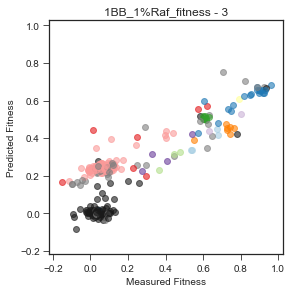

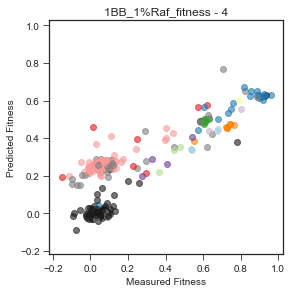

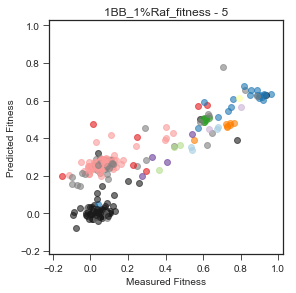

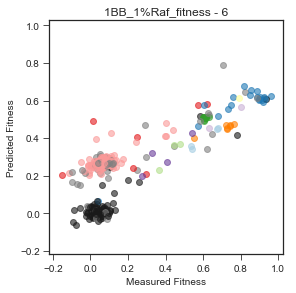

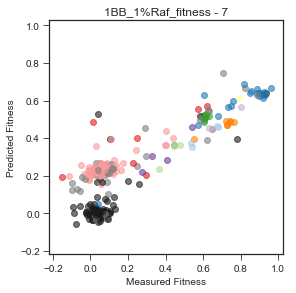

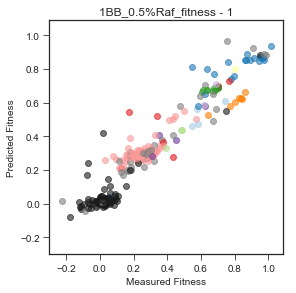

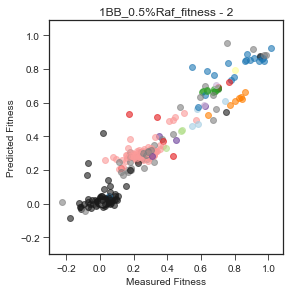

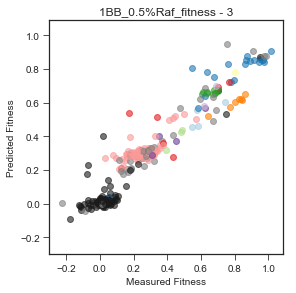

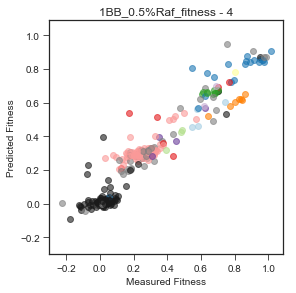

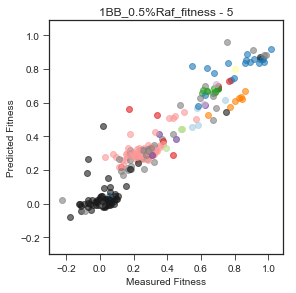

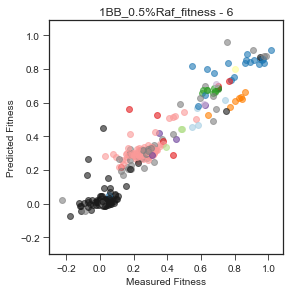

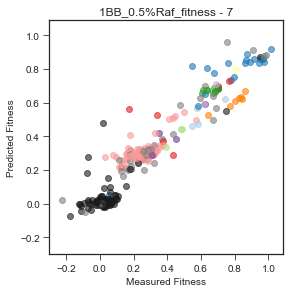

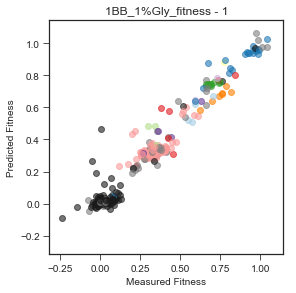

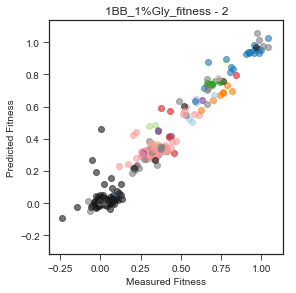

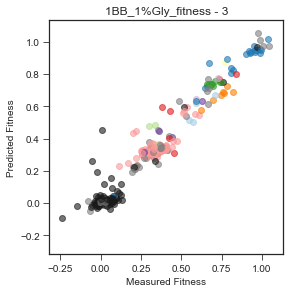

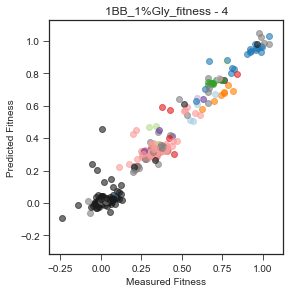

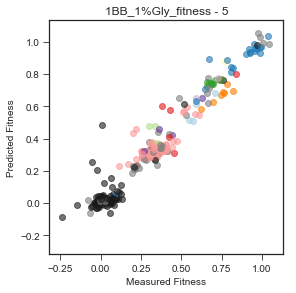

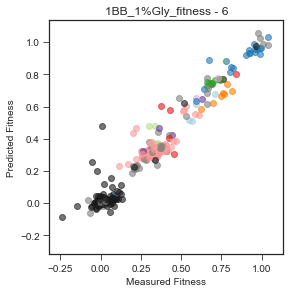

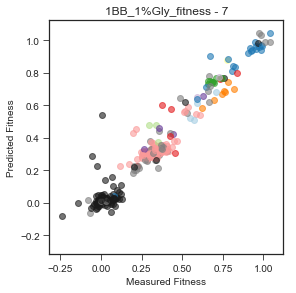

In [97]:
test_mutant_data = this_data[~this_data['barcode'].isin(training_bcs)]


# this_gene = ['GPB2','PDE2','IRA1','Diploid']
# this
# this_gene_data = test_mutant_data[test_mutant_data['gene'].isin(this_gene)]

this_gene_data = test_mutant_data

# type_list = ['nonsense_variant','frameshift_variant']
# type_list = ['missense_variant']
# this_gene_data = this_gene_data[this_gene_data['type'].isin(type_list)]


this_gene_locs = np.where(np.isin(test_mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[train_conditions[0]].values)) ]

for i,col in enumerate(test_conditions):
    for rank in range(len(guesses)):
        plt.figure()
        plt.title(f'{col} - {rank+1}')
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter(this_gene_data[col].values[bc],guesses[rank][this_gene_locs[bc],i],color=mutant_colorset[this_gene_data['gene'].values[bc]],alpha=0.6)
        
        xmin,xmax = plt.xlim()
        ymin,ymax = plt.ylim()
        plt.xlim(min(xmin,ymin),max(xmax,ymax))
        plt.ylim(min(xmin,ymin),max(xmax,ymax))
        plt.tight_layout()
        plt.gca().set_aspect('equal')
        plt.xlabel('Measured Fitness')
        plt.ylabel('Predicted Fitness')
        plt.savefig(f'predictions_by_gene_sidebyside_permuted_{col}_{rank+1}components.pdf',bbox_inches='tight')

In [12]:
p = Pool(10)
entries = [[this_fitness,train,test,n_components] for n_components in range(1,25)]
# (,by_condition=True,by_mutant=False)
output = p.starmap(tools.SVD_predictions_train_test_mixnmatch,entries)

KeyboardInterrupt: 

Process ForkPoolWorker-39:
Process ForkPoolWorker-35:
Process ForkPoolWorker-38:
Process ForkPoolWorker-40:
Process ForkPoolWorker-32:
Process ForkPoolWorker-37:
Process ForkPoolWorker-34:
Process ForkPoolWorker-33:
Process ForkPoolWorker-36:
Process ForkPoolWorker-31:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framewo

  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1724, in pinv
    u, s, vt = svd(a, full_matrices=False)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1444, in svd
    u, s, vh = gufunc(a, signature=signature, extobj=extobj)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1444, in svd
    u, s, vh = gufunc(a, signature=signature, extobj=extobj)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1444, in svd
    u, s, vh = gufunc(a, signature=signature, extobj=extobj)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg

In [36]:
%%time
if __name__ ==  '__main__': 
    p = Pool(10)
    entries = [[this_fitness,train,test,n_components,False,False] for n_components in range(1,8)]
    # (,by_condition=True,by_mutant=False)
    output = p.starmap(tools.SVD_predictions_train_test_mixnmatch,entries)

CPU times: user 1min 36s, sys: 1min 20s, total: 2min 56s
Wall time: 1h 13min 51s


In [50]:
output[0][0]

[0.7775464290186149,
 -1.7462627649199987,
 -1.7322641952199276,
 -1.8075848574009248,
 -1.8071511589631837,
 -1.8039558786969931,
 -1.8103381478808624,
 -1.8074569334136434,
 -1.7884100100802862,
 -1.794749121032754,
 -1.8362844687658728,
 -1.8034855936533494,
 -1.893842230766019,
 -1.8112373698713573,
 -1.816097188453781,
 -1.8124588165782156,
 -1.8164305059075976,
 -1.8163543693231108,
 -1.8102422591361833,
 -1.796341314905836,
 -1.8078083617314307,
 -1.804494066515543,
 -1.8175237432201117,
 -1.794151939431321]

In [54]:
sort_list = []
for o in output:
    sort_list.append(sorted([(o1,o2) for o1,o2 in zip(o[0],o[4])],reverse=True))
    

In [55]:
sorted_rank_combos = sort_list

RuntimeError: Failed to open TrueType font

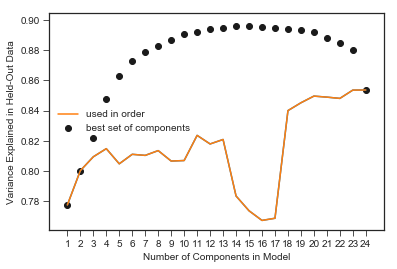

In [57]:
by_rank, by_condition, by_mutant, mean_fits = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=False)
# by_condition = np.asarray(by_condition).swapaxes(0,1)

condition_colors = sns.color_palette()
plt.plot(by_rank)

for rank in range(len(sorted_rank_combos)):
    plt.scatter(rank,sorted_rank_combos[rank][0][0],color='k',label='best set of components' if rank ==0 else '_nolegend_')
plt.plot(by_rank,label='used in order')
# plt.savefig('predictions_best_per_rank.pdf',bbox_inches='tight')
plt.xticks(range(len(by_rank)),range(1,len(by_rank)+1))
plt.xlabel('Number of Components in Model')
plt.ylabel('Variance Explained in Held-Out Data')
plt.legend()
plt.savefig('best_set_vs_in_order_all.pdf',bbox_inches='tight')

In [31]:
%%time
o = []
for n_components in range(1,5):
    by_rank, by_condition, by_mutant, mean_fits, component_sets = tools.SVD_predictions_train_test_mixnmatch(this_fitness,train,test,n_components,by_condition=True,by_mutant=False)
    o.append(sorted([(rank,combo) for rank,combo in zip(by_rank,component_sets)],reverse=True))



CPU times: user 15.1 s, sys: 470 ms, total: 15.6 s
Wall time: 34.6 s


In [63]:
sorted_rank_combos[6]

[(0.8785819075879436, [0, 1, 2, 9, 10, 12, 17]),
 (0.8770446318593077, [0, 1, 2, 7, 10, 12, 17]),
 (0.8763761257533184, [0, 1, 2, 3, 10, 12, 17]),
 (0.876272100070757, [0, 1, 2, 5, 10, 12, 17]),
 (0.8752940410415991, [0, 1, 2, 10, 12, 17, 19]),
 (0.8739377955644658, [0, 1, 2, 10, 12, 16, 17]),
 (0.8737460397343314, [0, 1, 2, 6, 10, 12, 17]),
 (0.873565355369854, [0, 1, 2, 10, 11, 12, 17]),
 (0.87297186151656, [0, 1, 2, 3, 8, 10, 17]),
 (0.8727238941920381, [0, 1, 2, 10, 12, 17, 23]),
 (0.8723689696864775, [0, 1, 2, 10, 12, 17, 21]),
 (0.8722390689577192, [0, 1, 2, 10, 12, 17, 20]),
 (0.8714454687763196, [0, 1, 2, 7, 8, 10, 17]),
 (0.8713969764924173, [0, 1, 2, 8, 10, 17, 19]),
 (0.8708718512808002, [0, 1, 2, 10, 12, 17, 18]),
 (0.8708306655632606, [0, 1, 2, 5, 8, 10, 17]),
 (0.8707817426646477, [0, 1, 2, 8, 10, 14, 17]),
 (0.8707719842860515, [0, 1, 2, 3, 5, 10, 17]),
 (0.8704256336135026, [0, 1, 2, 8, 10, 16, 17]),
 (0.870276423848967, [0, 1, 2, 3, 7, 10, 17]),
 (0.8699833141457991, [

In [ ]:
this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

bests = []
ranks = []

# train_cols = [col + '_fitness' for col in m3_conditions]
# test_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in train_cols]
# test_cols = test_cols + [col + '_fitness' for col in old_nonm3_conditions]

train_cols = [col + '_fitness' for col in train_cols]
test_cols = [col + '_fitness' for col in test_cols]

fitness_cols = train_cols + test_cols

train_locs = np.where(np.isin(fitness_cols,train_cols))[0]
test_locs = np.where(np.isin(fitness_cols,test_cols))[0]

all_locs = sorted(list(train_locs)+list(test_locs))

fitness = this_data[fitness_cols].values
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]

this_fitness = fitness[:,all_locs]

test_mutants = np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]

mean_guess = tools.var_explained(this_fitness[test_mutants,:][:,new_test_locs],np.repeat(np.mean(this_fitness[test_mutants,:][:,new_train_locs],axis=1),len(new_test_locs)).reshape(len(test_mutants),len(new_test_locs)))

for bootstrap in [False]+ list(range(100)):
    if bootstrap != False:
        train_cols = [col.split('_fitness')[0] + f'_bootstrap{bootstrap}_fitness' for col in train_cols]
        test_cols = [col for col in bigbatch_conditions.keys() if (col) not in train_cols]

    else:
        train_cols = [col for col in train_cols]
        test_cols = [col for col in bigbatch_conditions.keys() if (col) not in train_cols]


    fitness_cols = train_cols + test_cols

    fitness = this_data[fitness_cols].values

    n_mutants = fitness.shape[0]
    n_conditions = fitness.shape[1]
    
    train_conditions = train_cols

    # train_conditions = test_cols
    train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

    test_conditions = test_cols
    # test_conditions = train_cols
    # test_conditions = [rep for rep in  test_conditions if rep.split('_')[0] in all_reps]
    test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]




    all_locs = sorted(list(train_locs)+list(test_locs))

    this_fitness = fitness[:,all_locs]
    new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
    new_test_locs = np.where(np.isin(all_locs,test_locs))[0]



    train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
    test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]


    by_rank, by_condition, by_mutant, mean_fits, guesses = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=True)
    by_condition = np.asarray(by_condition).swapaxes(0,1)
    
#     bests.append(max(by_rank))
    bests.append(by_rank[1])
    
    ranks.append(np.where(by_rank==max(by_rank))[0])


